In [1]:
from astropy.io import fits
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
np.seterr(divide='ignore', invalid='ignore');
plt.rcParams.update({'figure.max_open_warning': 0})
import scipy.stats as stats
import astropy.units as u
from astropy.table import Table, Column, MaskedColumn, join
from tqdm import tqdm
from bisect import bisect_left
c = 2.998e10
k = 1.38e-16
h = 6.626e-27
plt.rcParams.update({'font.size': 22})
halpha = 6564.61
hbeta = 4862.68
hgamma = 4341.68
hdelta = 4102.89
plt.rcParams['figure.figsize'] = [15, 10]
from IPython.display import Audio, display
def allDone():
    display(Audio(filename='beep.mp3', autoplay=True))
from scipy.interpolate import interp1d,InterpolatedUnivariateSpline
import lmfit

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx
import emcee
import corner
import numdifftools
from scipy.ndimage import interpolation
from scipy.signal import medfilt
from scipy.interpolate import interp1d
from multiprocessing import Pool
import pickle
import h5py
import multiprocessing
import itertools
from multiprocessing import sharedctypes
import scipy
from PyAstronomy.pyasl import dopplerShift

In [2]:
def get_spectrum(source_id):
    path = wdtable[wdtable['source_id'] == source_id][0]['specpath']
    try:
        f = fits.open(path)
        flux = f[1].data['flux']
        loglam = f[1].data['loglam']
        f.close()
        lam = 10**loglam
    except:
        print('Spectrum file missing...')
        return
    return lam,flux

In [3]:
filetable = Table.read('filetable.fits')
wdtable = Table.read('tremblay_final.fits')
print(len(wdtable))
wdtable = join(filetable,wdtable,keys = ['source_id','Teff','log_g','spectral_class','S/N'])

DA = (wdtable['spectral_class'] == 'DA')*(~np.isnan(wdtable['Teff']))*(~np.isnan(wdtable['log_g']))*\
        (wdtable['S/N'] > 50)*(wdtable['spec_Teff'] < 80000)
wdtable = wdtable[DA]
len(wdtable)

5396


223

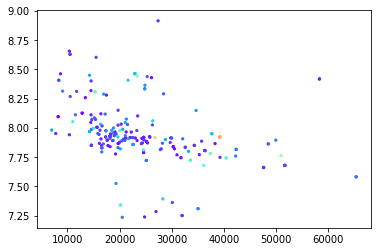

In [4]:
plt.scatter(wdtable['spec_Teff'],wdtable['spec_logg'], s = 5, c = wdtable['S/N'], vmax = 100, cmap = 'rainbow')

In [5]:
interpfluxs = [];
lamgrid = np.arange(4000,8000)
for i in tqdm(range(len(wdtable))):
    spec = get_spectrum(wdtable['source_id'][i])
    lam  = spec[0]
    flux = spec[1]
    #trans = ((wdtable['center_b'][i] - hbeta)+(wdtable['center_a'][i]-halpha))/2
    #shiftedflux = interpolation.shift(flux,-trans,cval=np.nan)
    func = interp1d(lam,flux,kind='linear',assume_sorted = False,fill_value='extrapolate')
    interpflux = func(lamgrid)
    interpfluxs.append(interpflux)

100%|██████████| 223/223 [00:15<00:00, 14.43it/s]


In [6]:
spectra = np.asarray(interpfluxs)
continuum = pickle.load(open('continuumwls.p','rb'))
lamgrid = np.arange(4000,8000)

In [7]:
def adapted_ch_cont(array,continuum):
    spec = array
    notnan = ~np.isnan(spec)
    p = np.polynomial.chebyshev.chebfit(lamgrid[continuum*notnan],spec[continuum*notnan],5)
    contcorr = spec / np.polynomial.chebyshev.chebval(lamgrid,p)
    return contcorr

In [8]:
def norm_dataspec(array):
    contcorr = adapted_ch_cont(array,continuum)
    skylinemask = (lamgrid > 5578.5 - 10)*(lamgrid < 5578.5 + 10) + (lamgrid > 5894.6 - 10)*(lamgrid < 5894.6 + 10)\
        + (lamgrid > 6301.7 - 10)*(lamgrid < 6301.7 + 10) + (lamgrid > 7246.0 - 10)*(lamgrid < 7246.0 + 10)
    contcorr[skylinemask] = 1
    where = np.isnan(contcorr)+(contcorr > 1.25) + (contcorr < 0)
    contcorr[where] = 1
    return contcorr

In [9]:
wdtable['spectrum'] = spectra

In [10]:
clamgrid = np.linspace(4000,7000,3000)

In [11]:
import numpy as np
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize,scale,MinMaxScaler,StandardScaler
import multiprocessing

Using TensorFlow backend.


In [12]:
sc = pickle.load(open('koesterddsc.p','rb'))
msc = pickle.load(open('koesterddmsc.p','rb'))

In [13]:
H = 128
def generator():
    x = Input(shape=(2,))
    y = Dense(H,activation='sigmoid')(x)
    y = Dense(H,activation='sigmoid')(y)
    y = Dense(H,activation='sigmoid')(y)
    y = Dense(H,activation='sigmoid')(y)
    out = Dense(4000,activation='linear')(y)
    
    model = Model(inputs = x, outputs = out)
    model.compile(optimizer = Adamax(), loss = 'mse', \
                  metrics = ['mae'])
    return model
model = generator()
history = [];
model.load_weights('model_interp_deep.h5')
print(model.summary())

W0924 12:13:09.570711 4660237760 deprecation_wrapper.py:119] From /Users/vedantchandra/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0924 12:13:09.587355 4660237760 deprecation_wrapper.py:119] From /Users/vedantchandra/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0924 12:13:09.591450 4660237760 deprecation_wrapper.py:119] From /Users/vedantchandra/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0924 12:13:09.643997 4660237760 deprecation_wrapper.py:119] From /Users/vedantchandra/anaconda3/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instea

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               384       
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_4 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_5 (Dense)              (None, 4000)              516000    
Total params: 565,920
Trainable params: 565,920
Non-trainable params: 0
_________________________________________________________________
None

Text(0.5, 0, 'Wavelength ($\\AA$)')

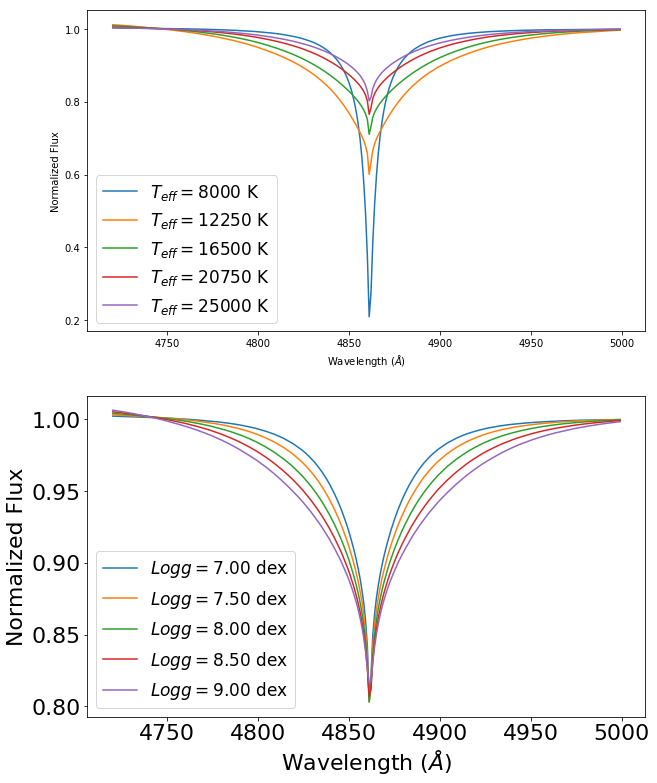

In [14]:
plt.figure(figsize=(10,13))

plt.subplot(211)
ts = np.linspace(8000,25000,5)
ls = np.linspace(8,8,5)
plt.rcParams.update({'font.size': 22})             
samples = sc.transform(np.stack((ts,ls)).transpose())
gens = msc.inverse_transform(model.predict(samples))
tscores = (ts - np.min(ts))/(np.max(ts) - np.min(ts))
for i in range(len(gens)):
    plt.plot(lamgrid[720:1000],norm_dataspec(gens[i])[720:1000],label='$T_{eff} = %i$ K'%ts[i])
plt.legend(fontsize=17)
plt.ylabel('Normalized Flux')
plt.xlabel('Wavelength ($\AA$)')

plt.subplot(212)
ts = np.linspace(25000,25000,5)
ls = np.linspace(7,9,5)
samples = sc.transform(np.stack((ts,ls)).transpose())
gens = msc.inverse_transform(model.predict(samples))
tscores = (ts - np.min(ts))/(np.max(ts) - np.min(ts))
for i in range(len(gens)):
    plt.plot(lamgrid[720:1000],norm_dataspec(gens[i])[720:1000],label='$Logg = %.2f$ dex'%ls[i])
plt.legend(fontsize=17)
plt.ylabel('Normalized Flux')
plt.xlabel('Wavelength ($\AA$)')

# Fitting

In [15]:
lines = ((lamgrid > hbeta-200) & (lamgrid < hbeta + 300)) | ((lamgrid > halpha-250) & (lamgrid < halpha + 300))\
        | ((lamgrid > hgamma-120) & (lamgrid < hgamma + 400))| ((lamgrid > hdelta-90) & (lamgrid < hdelta + 150))

def spectrum_sampler(wl,teff,logg,trans):
    label = sc.transform(np.asarray(np.stack((teff,logg)).reshape(1,-1)))
    synth = dopplerShift(wl,np.ravel(
                        msc.inverse_transform(
                                model.predict(label))[0]
                        ), trans*1000
                    )[0]
    return np.exp(np.ravel(synth).astype('float64'))

def norm_spectrum_sampler(wl,teff,logg,trans):
    synth = spectrum_sampler(lamgrid,teff,logg,trans)
    return adapted_ch_cont(synth,continuum)[lines]

def chisquare(residual):
    return sum(residual**2)

def get_prior_teff(array):
    spec = np.asarray(array)
    priorfitter = lmfit.Model(spectrum_sampler)
    priorparams = priorfitter.make_params()
    priorparams['logg'].set(value = 8., vary = False)
    priorparams['teff'].set(value = 10000,min = 5500, max = 80000)
    priorparams['trans'].set(value = 0., vary = False)
    priorfitter.eval(priorparams, wl = lamgrid)
    prior_result = priorfitter.fit(spec, priorparams, wl = lamgrid, method = 'Powell', nan_policy = 'omit');
    #print(prior_result.fit_report())
    return prior_result.params['teff'].value

def get_posteriors(array, n_eval = 3000):
    spec = array
    normspec = norm_dataspec(spec)
    def chisq(params):
        teff,logg,trans = params
        res = normspec[lines] - norm_spectrum_sampler(lamgrid,teff,logg,trans)
        res = res[~np.isnan(res)]
        chisq = np.sum(res**2)
        return chisq
    teff_init = get_prior_teff(spec)
   # p = scipy.optimize.minimize(chisq, bounds = [(5500,80000),(6.5,9.5),(-3,3)], x0 = [teff_init, 8., 0],\
                             #  method = 'dual_annealing')
    p = scipy.optimize.dual_annealing(chisq,bounds = [(5500,80000),(6.5,9.5),(-3,3)],maxfun = n_eval,\
                                      x0 = [teff_init, 8., 0])
    #p = scipy.optimize.differential_evolution(chisq,bounds = [(5500,80000),(6.5,9.5),(-3,3)],\
       #                              disp = True)
    
#     plt.plot(normspec[lines])
#     plt.plot(norm_spectrum_sampler(lamgrid,p.x[0],p.x[1],p.x[2]))
    return p.x

#### Evaluate NFev

### Evaluate on Synthetics

### Fit SDSS

In [196]:
fitparams = [];
for ii in tqdm(range(len(wdtable))):
    fitparams.append(get_posteriors(wdtable['spectrum'][ii]))
    
fitparams = np.asarray(fitparams)

100%|██████████| 10/10 [01:02<00:00,  6.20s/it]


In [197]:
fitparams = np.asarray(fitparams)

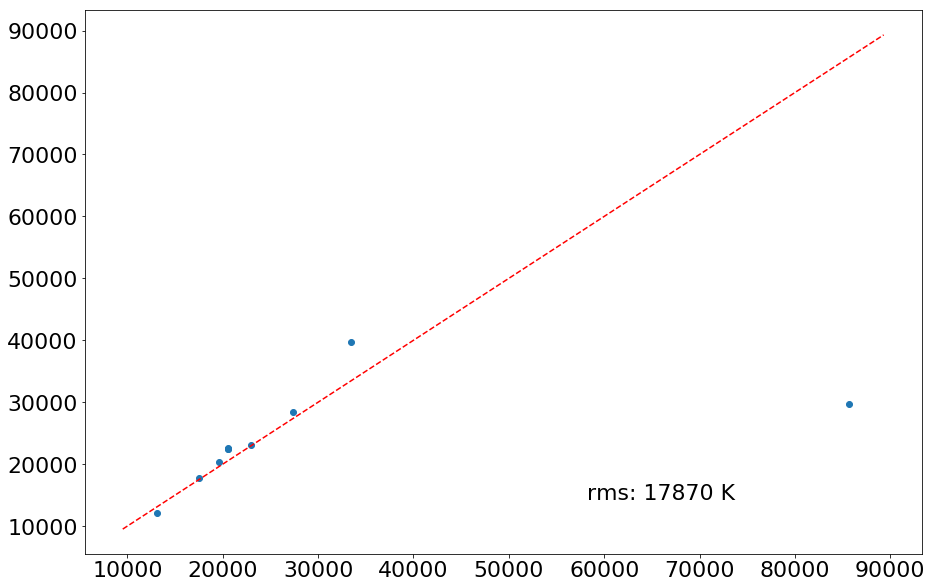

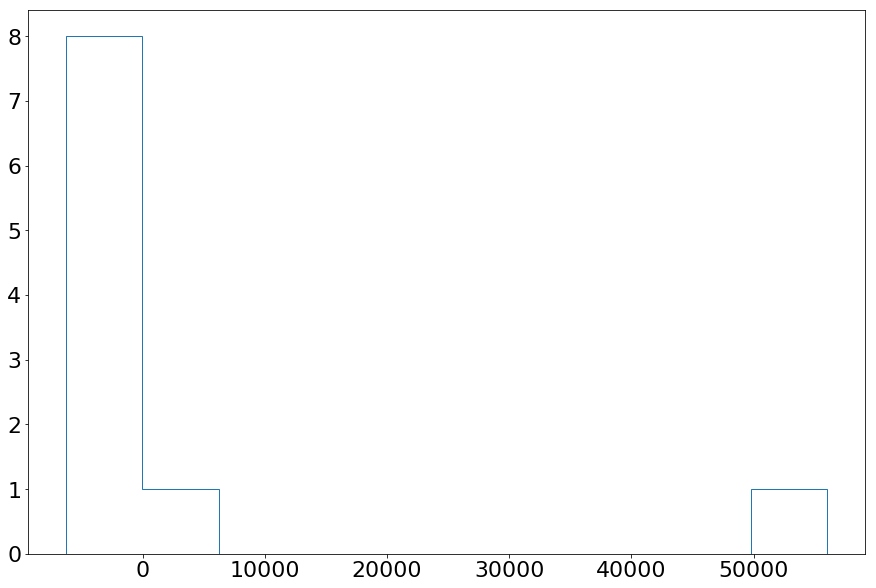

In [198]:
resid = wdtable['Teff'][0:len(fitparams)]-fitparams[:,0]
rms = np.sqrt(np.mean(resid**2))
f = plt.scatter(wdtable['Teff'][0:len(fitparams)],fitparams[:,0])
plt.text(0.6,0.1,'rms: %i K'%rms,transform = f.axes.transAxes)
x = np.linspace(f.axes.get_xlim()[0],f.axes.get_xlim()[1],1000)
y = x
plt.plot(x,y,'r--')
plt.figure()
plt.hist(resid, histtype = 'step');

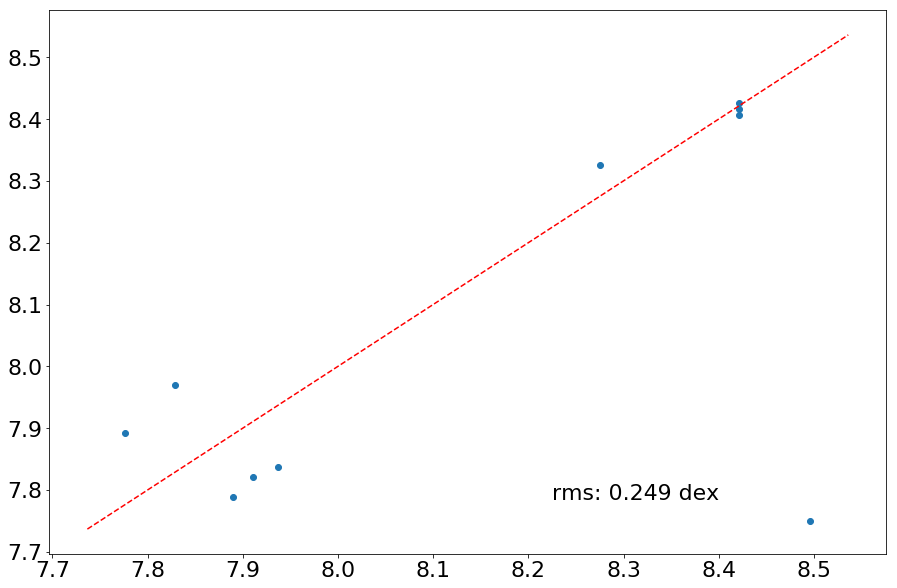

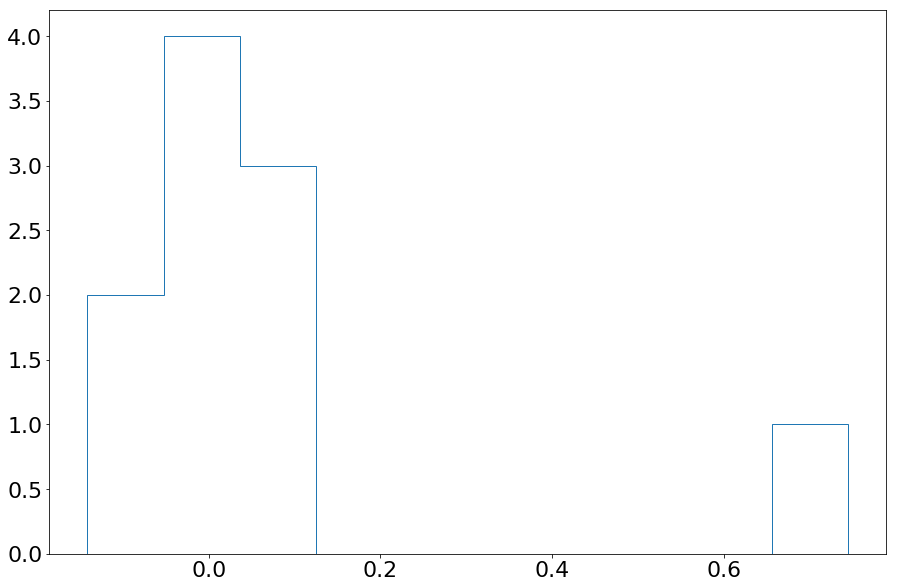

In [199]:
resid = wdtable['log_g'][0:len(fitparams)]-fitparams[:,1]
rms = np.sqrt(np.mean(resid**2))
f = plt.scatter(wdtable['log_g'][0:len(fitparams)],fitparams[:,1])
plt.text(0.6,0.1,'rms: %.3f dex'%rms,transform = f.axes.transAxes)
x = np.linspace(f.axes.get_xlim()[0],f.axes.get_xlim()[1],1000)
y = x
plt.plot(x,y,'r--')
plt.figure()
plt.hist(resid, histtype = 'step');

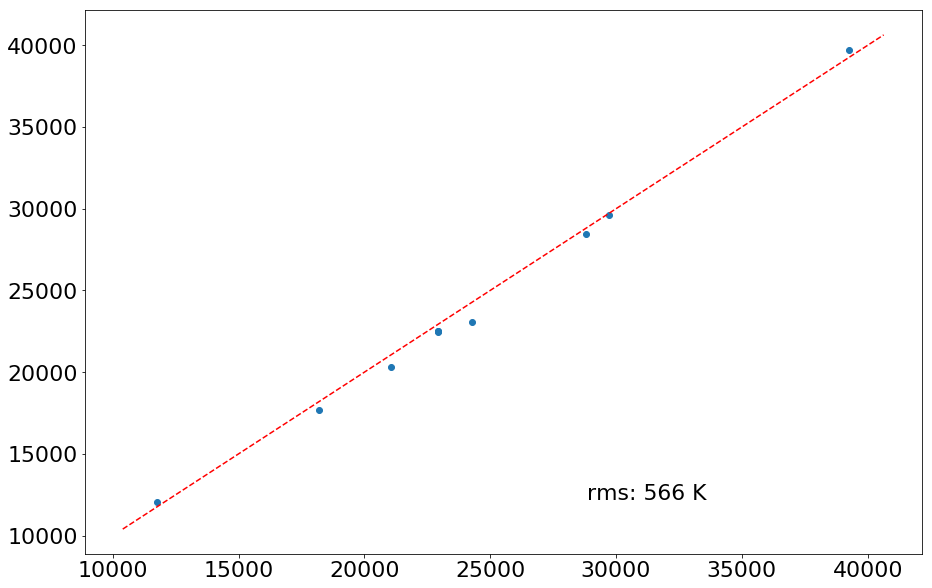

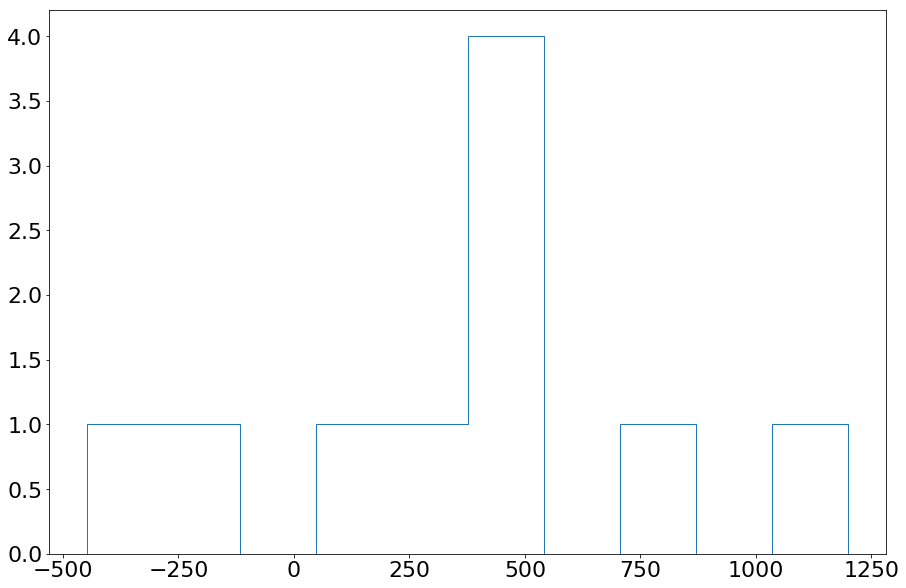

In [200]:
resid = wdtable['spec_Teff'][0:len(fitparams)]-fitparams[:,0]
rms = np.sqrt(np.mean(resid**2))
f = plt.scatter(wdtable['spec_Teff'][0:len(fitparams)],fitparams[:,0])
plt.text(0.6,0.1,'rms: %i K'%rms,transform = f.axes.transAxes)
x = np.linspace(f.axes.get_xlim()[0],f.axes.get_xlim()[1],1000)
y = x
plt.plot(x,y,'r--')
plt.figure()
plt.hist(resid, histtype = 'step');

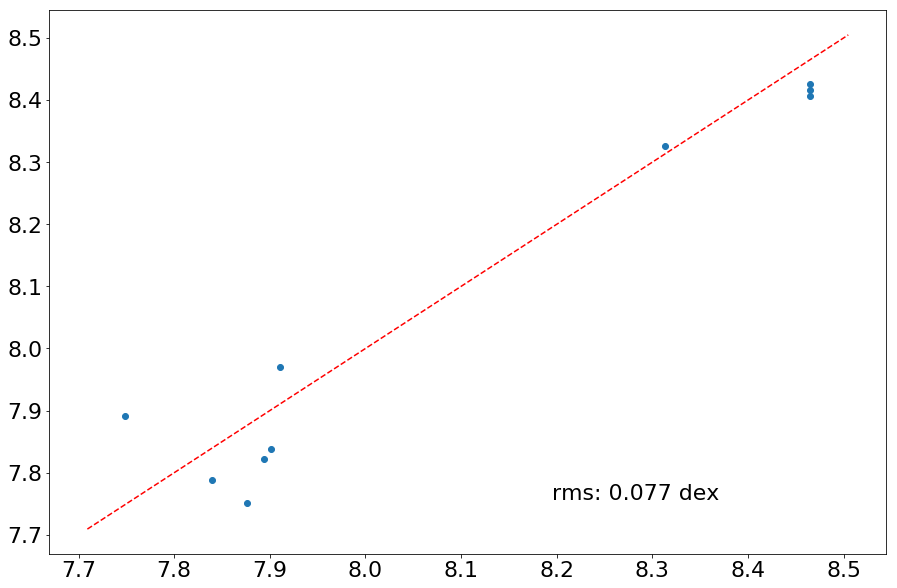

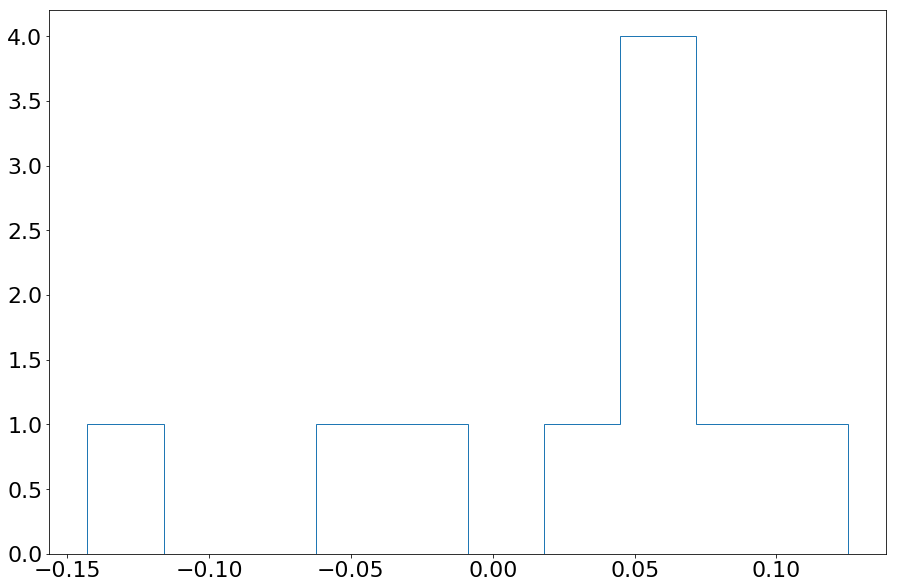

In [201]:
resid = wdtable['spec_logg'][0:len(fitparams)]-fitparams[:,1]
rms = np.sqrt(np.mean(resid**2))
f = plt.scatter(wdtable['spec_logg'][0:len(fitparams)],fitparams[:,1])
plt.text(0.6,0.1,'rms: %.3f dex'%rms,transform = f.axes.transAxes)
x = np.linspace(f.axes.get_xlim()[0],f.axes.get_xlim()[1],1000)
y = x
plt.plot(x,y,'r--')
plt.figure()
plt.hist(resid, histtype = 'step');

### MCMC Fitting



  0%|          | 0/1 [00:00<?, ?it/s]

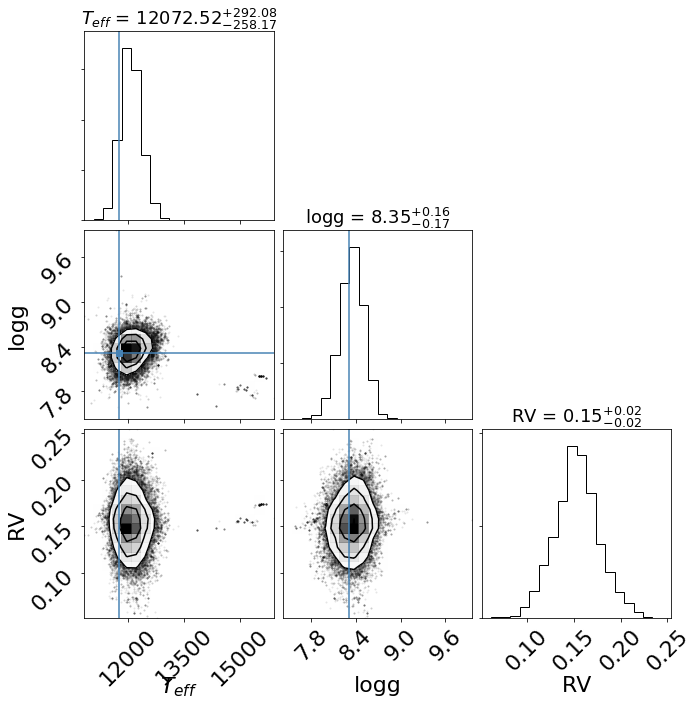

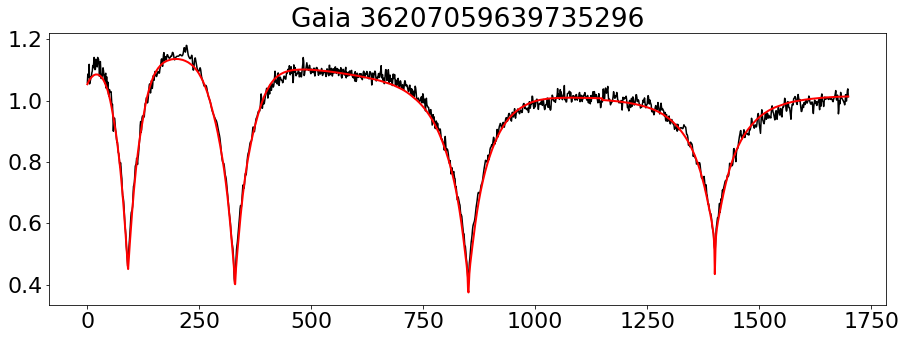



100%|██████████| 1/1 [01:22<00:00, 82.69s/it]

In [102]:
results = [];
for ii in tqdm(range(len(wdtable[0:1]))):
    spec = interpfluxs[ii]
    normspec = norm_dataspec(spec)[lines]
    teff_prior = get_prior_teff(spec)

    def lnlike(prms):
        err = 0.1
        model = norm_spectrum_sampler(lamgrid,prms[0],prms[1],prms[2])
        diff = model - normspec
        diff = diff[~np.isnan(diff)]
        chisq = np.sum(diff**2/err**2)
        lnlike = -0.5 * chisq

    #     plt.plot(model)
    #     plt.plot(normspec)
        return lnlike

    def lnprior(prms):
        if prms[0] < 6000 or prms[0] > 80000:
            return -np.Inf
        elif prms[1] < 6.5 or prms[1] > 9.5:
            return -np.Inf
        elif prms[2] < -3 or prms[2] > 3:
            return -np.Inf

        mu = teff_prior
        sigma = 10000
        return np.log(1.0/(np.sqrt(2*np.pi)*sigma))-0.5*(prms[0]-mu)**2/sigma**2

    def lnprob(prms):
        lp = lnprior(prms)
        if not np.isfinite(lp):
            return -np.Inf
        return lp + lnlike(prms)


    ndim,nwalkers = 3,500


    steps = 100
    burn = 5

    p0 = np.asarray(get_posteriors(spec))
    pos0 = np.zeros((nwalkers,ndim))
    for jj in range(ndim):
        pos0[:,jj] = ( p0[jj] + 0.05*p0[jj]*np.random.randn(nwalkers) )

    sampler = emcee.EnsembleSampler(nwalkers,ndim,lnprob,threads = 1)
    b = sampler.run_mcmc(pos0,burn)
    sampler.reset()
    s = sampler.run_mcmc(b[0],steps)
    values = np.median(sampler.flatchain,0)
    meanvalues = np.mean(sampler.flatchain,0)
    modevalues = stats.mode(sampler.flatchain,0)[0]
    mlevalues = sampler.flatchain[np.argmax(sampler.flatlnprobability)]
    lower = np.quantile(sampler.flatchain,.3173,axis=0)
    upper = np.quantile(sampler.flatchain,.6827,axis=0)
    std = np.std(sampler.flatchain,axis=0)
    
    results.append([values, meanvalues, modevalues, mlevalues, lower, upper, std])
    
    fig,axs = plt.subplots(3,3,figsize=(10,10))
    #f = corner.corner(sampler.flatchain[:,0:2],show_titles = True,smooth = 0,labels = ('$T_{eff}$','logg'),title_kwargs={'fontsize':18}, fig = fig)
    f = corner.corner(sampler.flatchain,show_titles = True,smooth = 0,truths = (wdtable['spec_Teff'][ii],wdtable['spec_logg'][ii], rvs[ii]),labels = ('$T_{eff}$','logg','RV'),title_kwargs={'fontsize':18}, fig = fig)
#     plt.savefig('plots/synthmc/'+str(wdtable[ii]['source_id'])+'_corner.png')

    plt.figure(figsize = (15,5))
    plt.title('Gaia '+str(wdtable[ii]['source_id']))
    plt.plot(normspec,'k', label = 'Data Spectrum')
    plt.plot(norm_spectrum_sampler(lamgrid,mlevalues[0],mlevalues[1],mlevalues[2]),'r',label = 'Fitted Synthetic',linewidth=2)
    #plt.legend()
#     plt.savefig('plots/synthmc/'+str(wdtable[ii]['source_id'])+'_fit.png')
    plt.show()

In [103]:
mlevalues

array([1.20714102e+04, 8.33702350e+00, 1.49822056e-01])

In [98]:
np.argmax(sampler.lnprobability)

42189

In [101]:
sampler.chain[42189]

IndexError: index 42189 is out of bounds for axis 0 with size 500

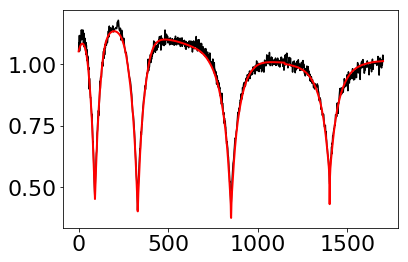

In [74]:
plt.plot(normspec,'k', label = 'Data Spectrum')
plt.plot(norm_spectrum_sampler(lamgrid,values[0],values[1],values[2]),'r',label = 'Fitted Synthetic',linewidth=2)


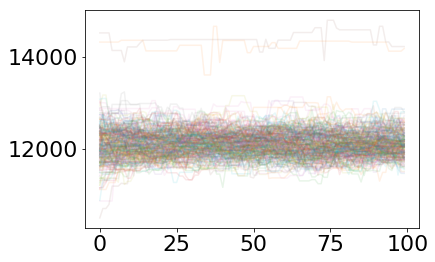

In [81]:
plt.plot(sampler.chain[:,:,0].T, alpha = 0.1);

In [19]:
results = np.asarray(results)

In [20]:
mles = results[:,3]
lowers = results[:,4]
uppers = results[:,5]
stds = results[:,6]

In [21]:
mles

array([array([1.39264800e+04, 8.83626107e+00, 0.00000000e+00])],
      dtype=object)

<IPython.core.display.Javascript object>


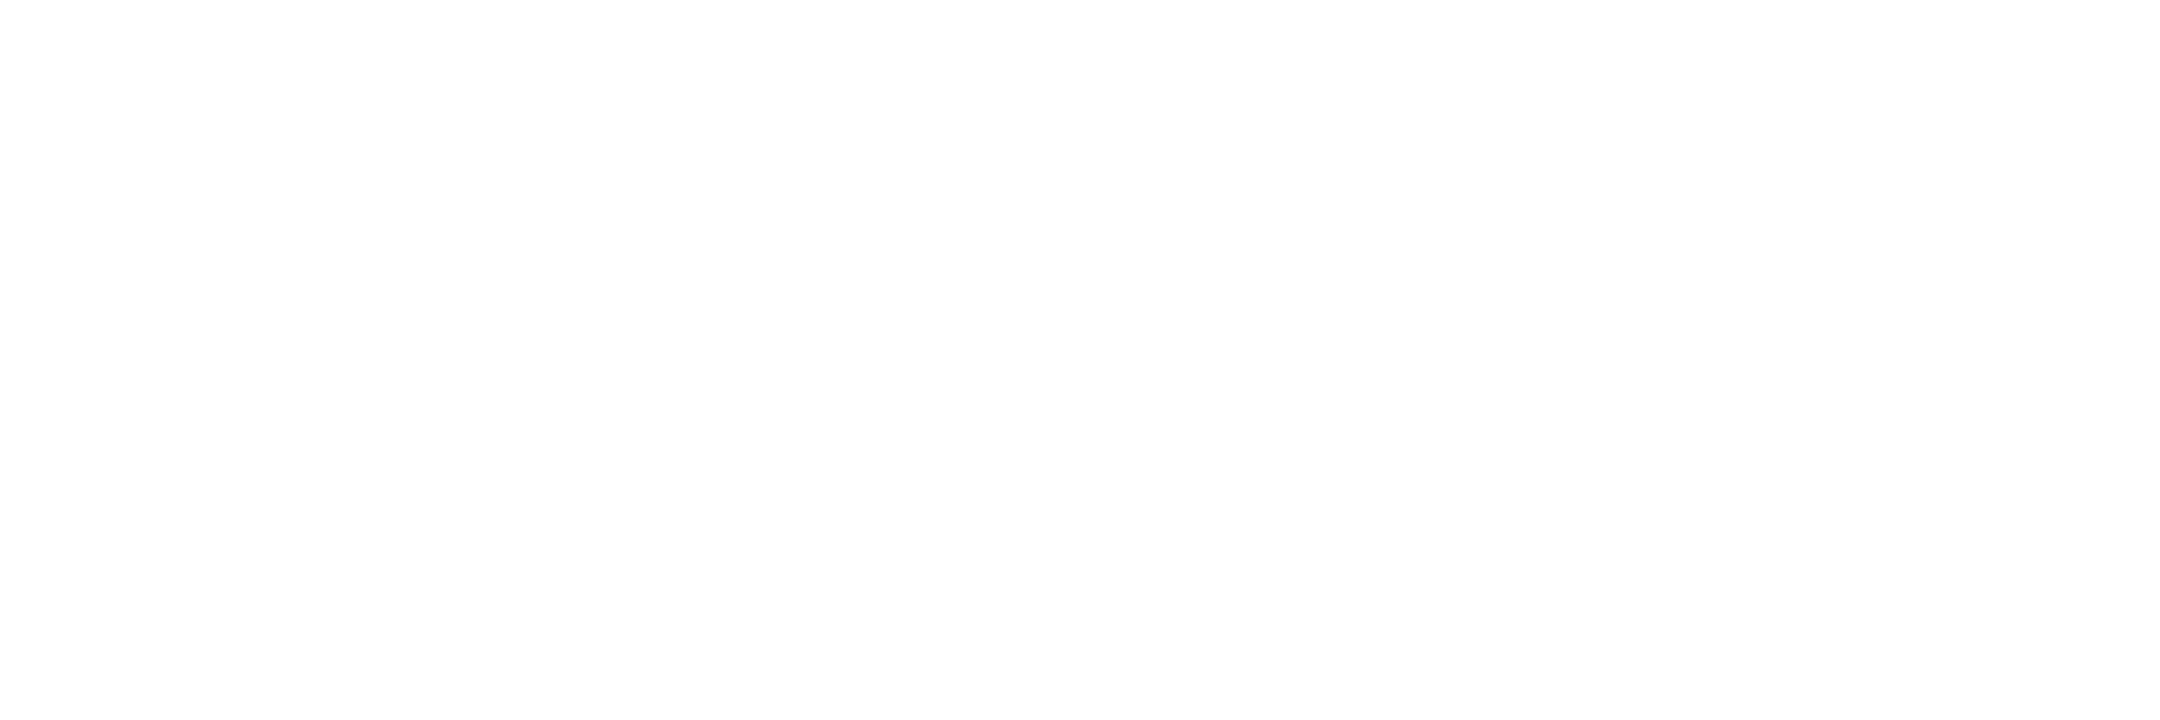

<IPython.core.display.Javascript object>


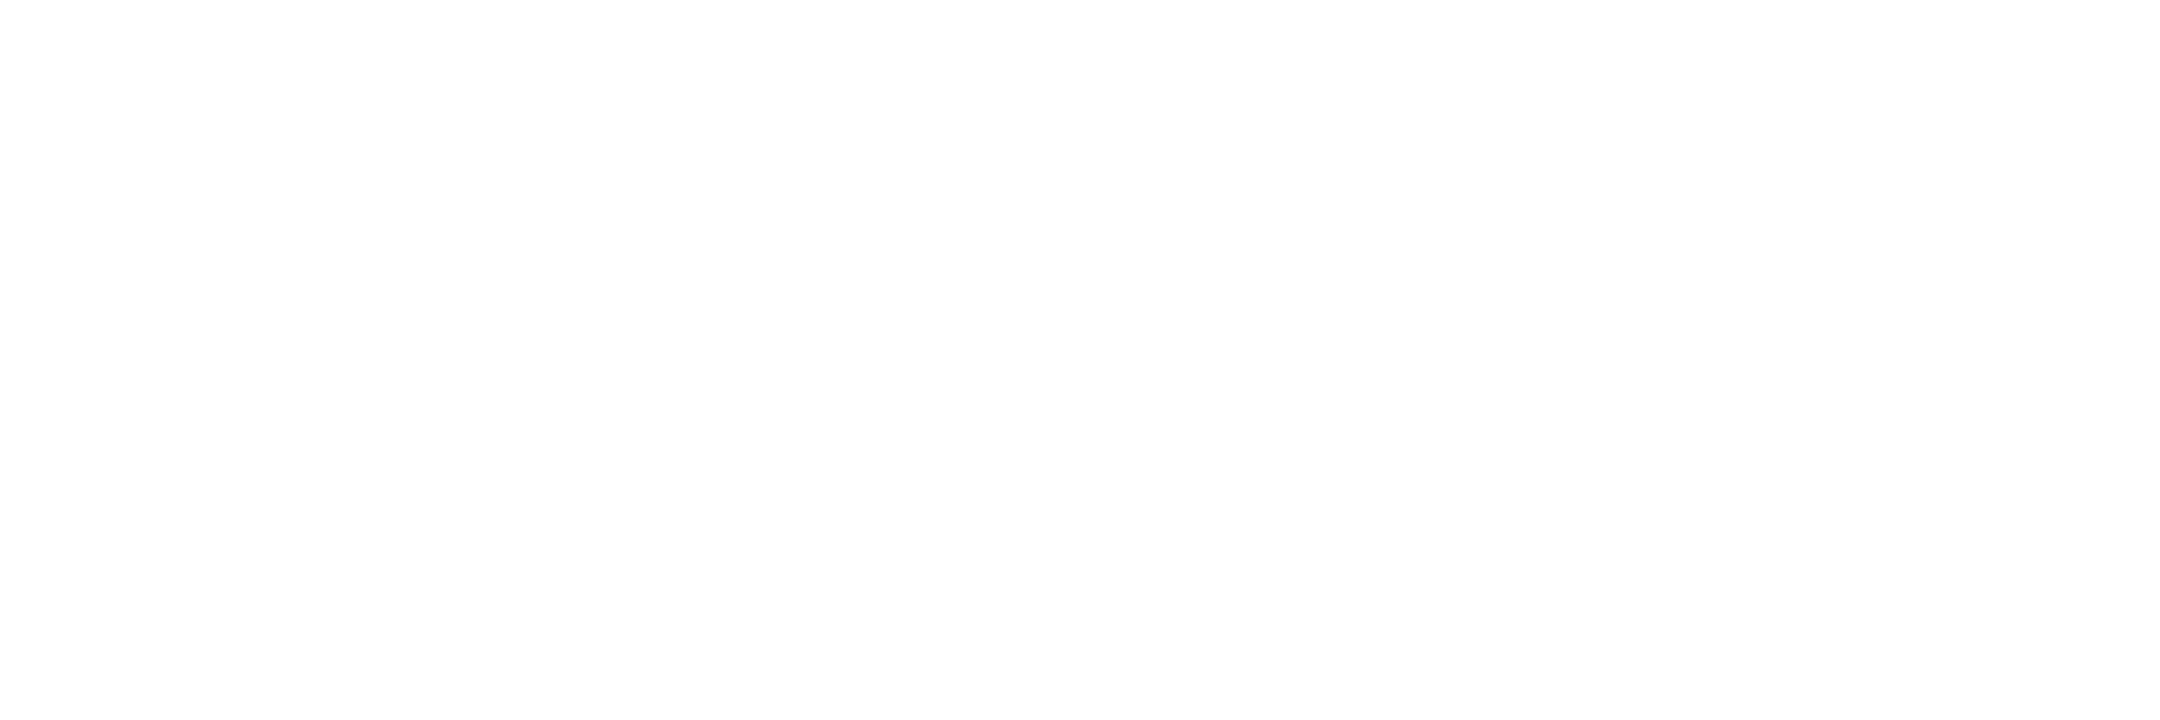

In [208]:
mleteff = [i[0] for i in mles]
lowteff = [i[0] for i in stds]
highteff = [i[0] for i in stds]
plt.figure(figsize=(15,5))
plt.subplot(121)
resid = wdtable['Teff'][0:len(mles)]-mleteff
rms = np.sqrt(np.mean(resid**2))
f = plt.scatter(wdtable['Teff'][0:len(mles)],mleteff, color = 'k')
plt.text(0.6,0.1,'rms: %i K'%rms,transform = f.axes.transAxes)
x = np.linspace(f.axes.get_xlim()[0],f.axes.get_xlim()[1],1000)
y = x
plt.plot(x,y,'r--')
plt.subplot(122)
plt.hist(resid, histtype = 'step');

<IPython.core.display.Javascript object>


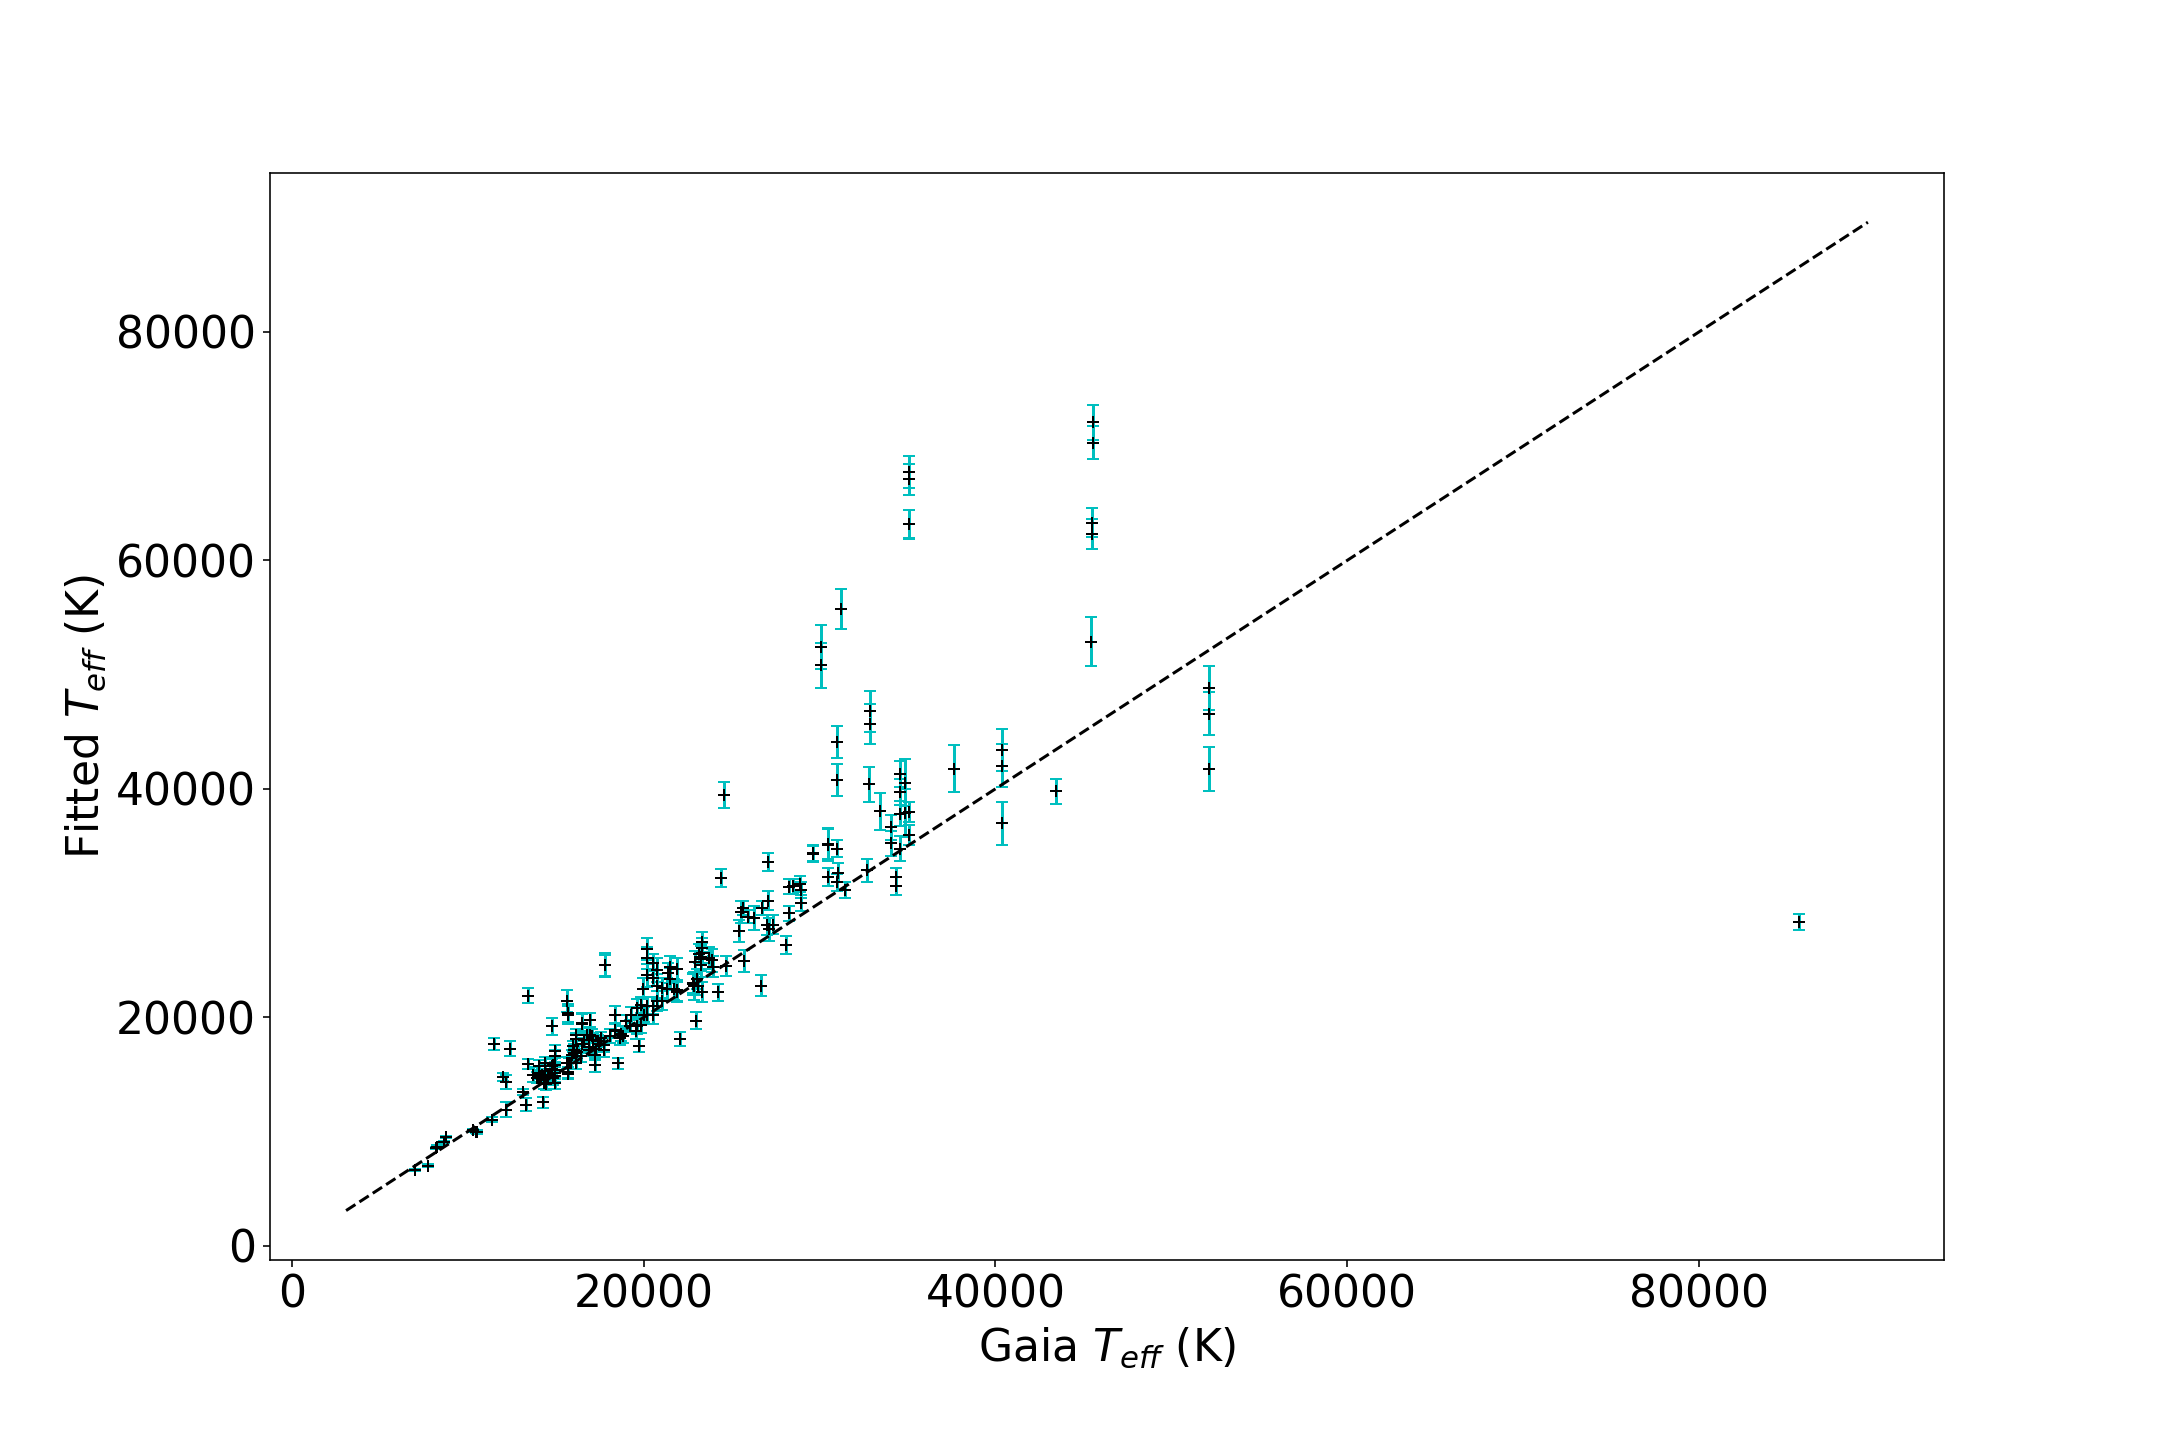

Text(0, 0.5, 'Fitted $T_{eff}$ (K)')

In [209]:
%matplotlib inline
mleteff = [i[0] for i in mles]
resid = wdtable['Teff'][0:len(mles)]-mleteff
rms = np.sqrt(np.mean(resid**2))
plt.figure(figsize = (15,10))
f = plt.subplot(111)
plt.errorbar(wdtable['Teff'][0:len(mles)],mleteff, yerr = (lowteff,highteff), linestyle = 'None', marker = '+',\
            color = 'k', ecolor = 'c', capsize = 3)
#plt.text(0.6,0.1,'rms: %i K'%rms,transform = f.axes.transAxes)
x = np.linspace(f.axes.get_xlim()[0],f.axes.get_xlim()[1],1000)
y = x
plt.plot(x,y,'k--')
plt.xlabel('Gaia $T_{eff}$ (K)')
plt.ylabel('Fitted $T_{eff}$ (K)')

<IPython.core.display.Javascript object>


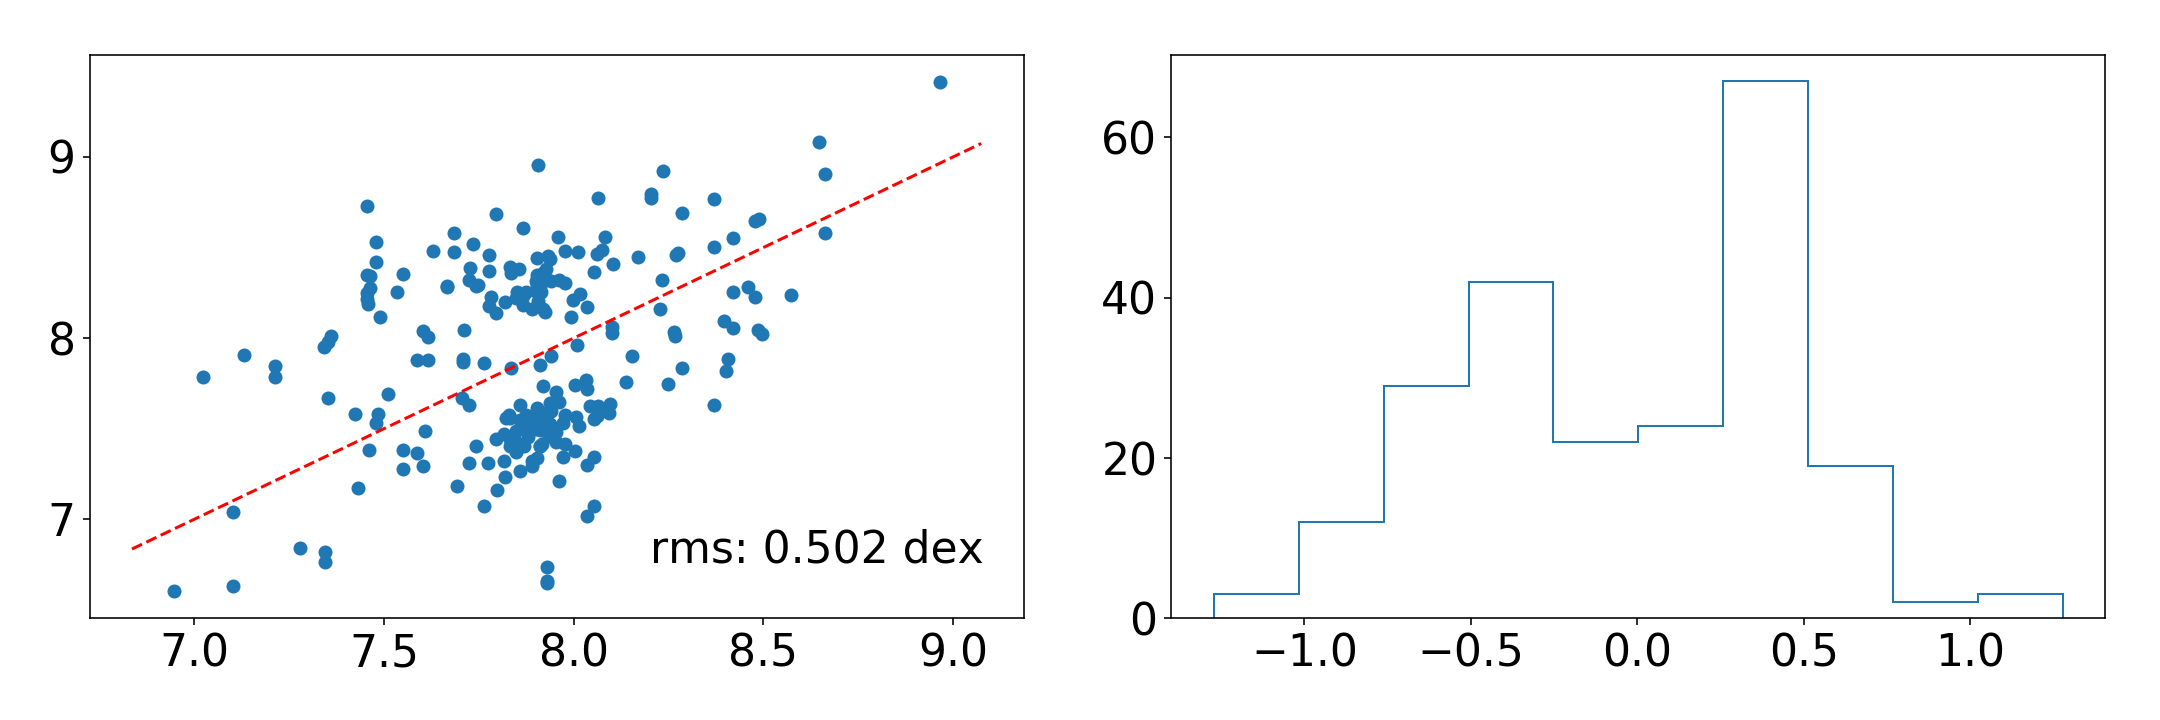

In [210]:
mlelog_g = [i[1] for i in mles]
lowlog_g = [i[1] for i in stds]
highlog_g = [i[1] for i in stds]
plt.figure(figsize=(15,5))
resid = wdtable['log_g'][0:len(mles)]-mlelog_g
rms = np.sqrt(np.mean(resid**2))
plt.subplot(121)
f = plt.scatter(wdtable['log_g'][0:len(mles)],mlelog_g)
plt.text(0.6,0.1,'rms: %.3f dex'%rms,transform = f.axes.transAxes)
x = np.linspace(f.axes.get_xlim()[0],f.axes.get_xlim()[1],1000)
y = x
plt.plot(x,y,'r--')
plt.subplot(122)
plt.hist(resid, histtype = 'step');
plt.tight_layout()

<IPython.core.display.Javascript object>


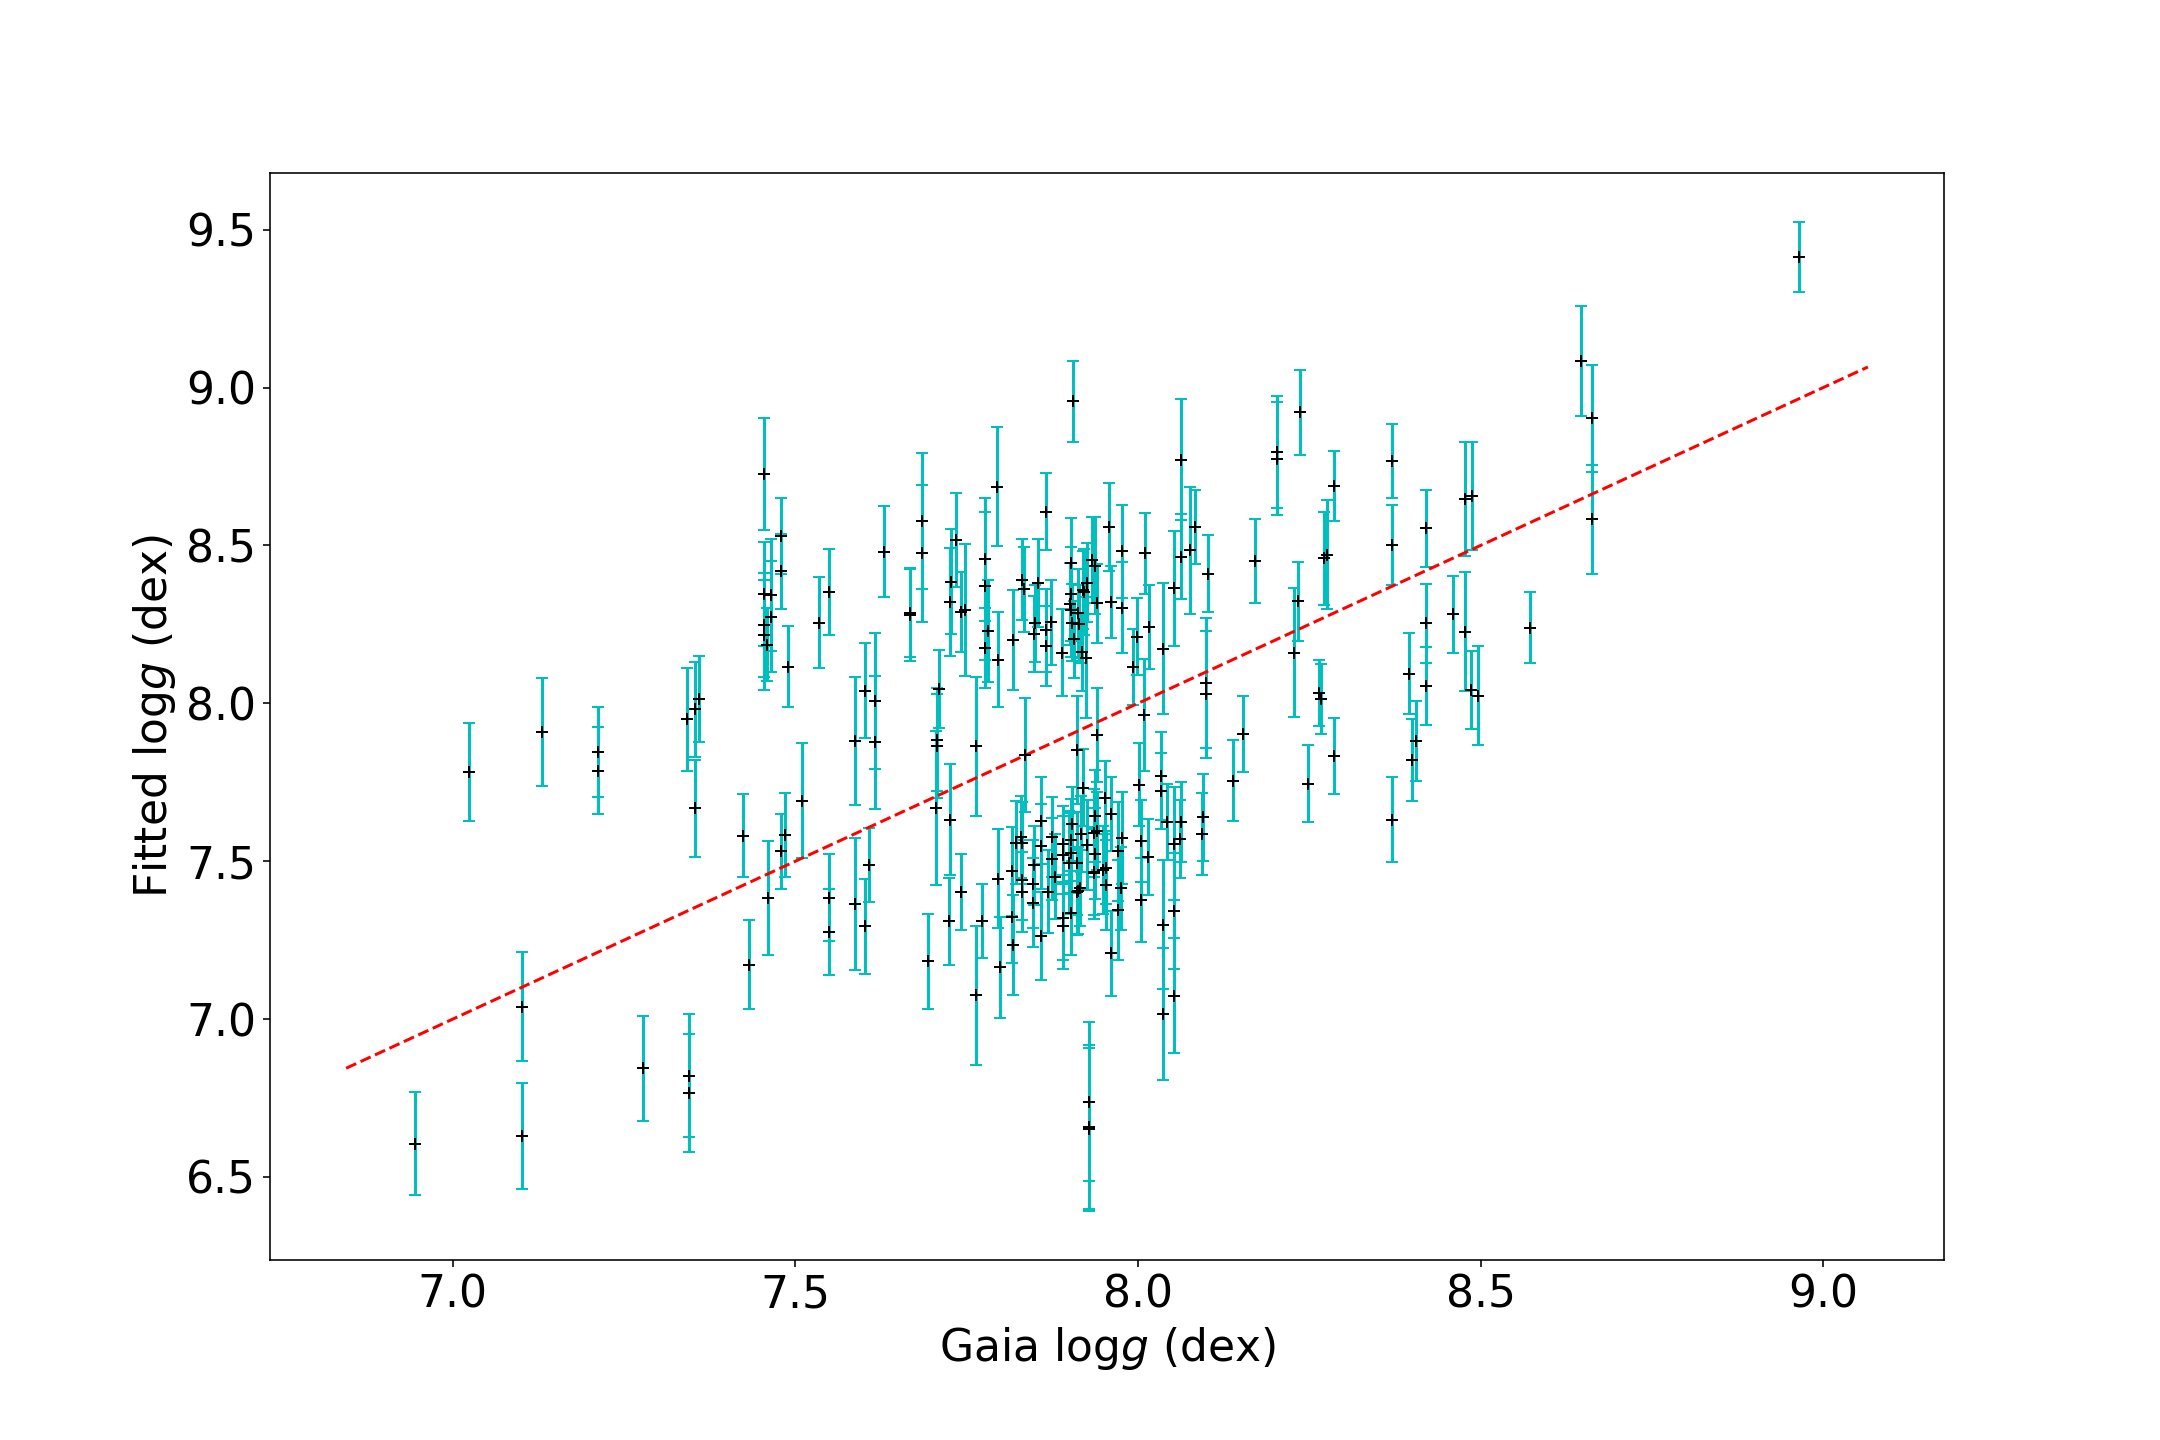

Text(0, 0.5, 'Fitted $\\log{g}$ (dex)')

In [211]:
mlelog_g = [i[1] for i in mles]
resid = wdtable['log_g'][0:len(mles)]-mlelog_g
rms = np.sqrt(np.mean(resid**2))
plt.figure(figsize = (15,10))
f = plt.subplot(111)
plt.errorbar(wdtable['log_g'][0:len(mles)],mlelog_g, yerr = (lowlog_g,highlog_g), linestyle = 'None', marker = '+',\
            color = 'k', ecolor = 'c', capsize = 3)
#plt.text(0.6,0.1,'rms: %.2f dex'%rms,transform = f.axes.transAxes)
x = np.linspace(f.axes.get_xlim()[0],f.axes.get_xlim()[1],1000)
y = x
plt.plot(x,y,'r--')
plt.xlabel('Gaia $\log{g}$ (dex)')
plt.ylabel('Fitted $\log{g}$ (dex)')

### Compare to Tremblay

<IPython.core.display.Javascript object>


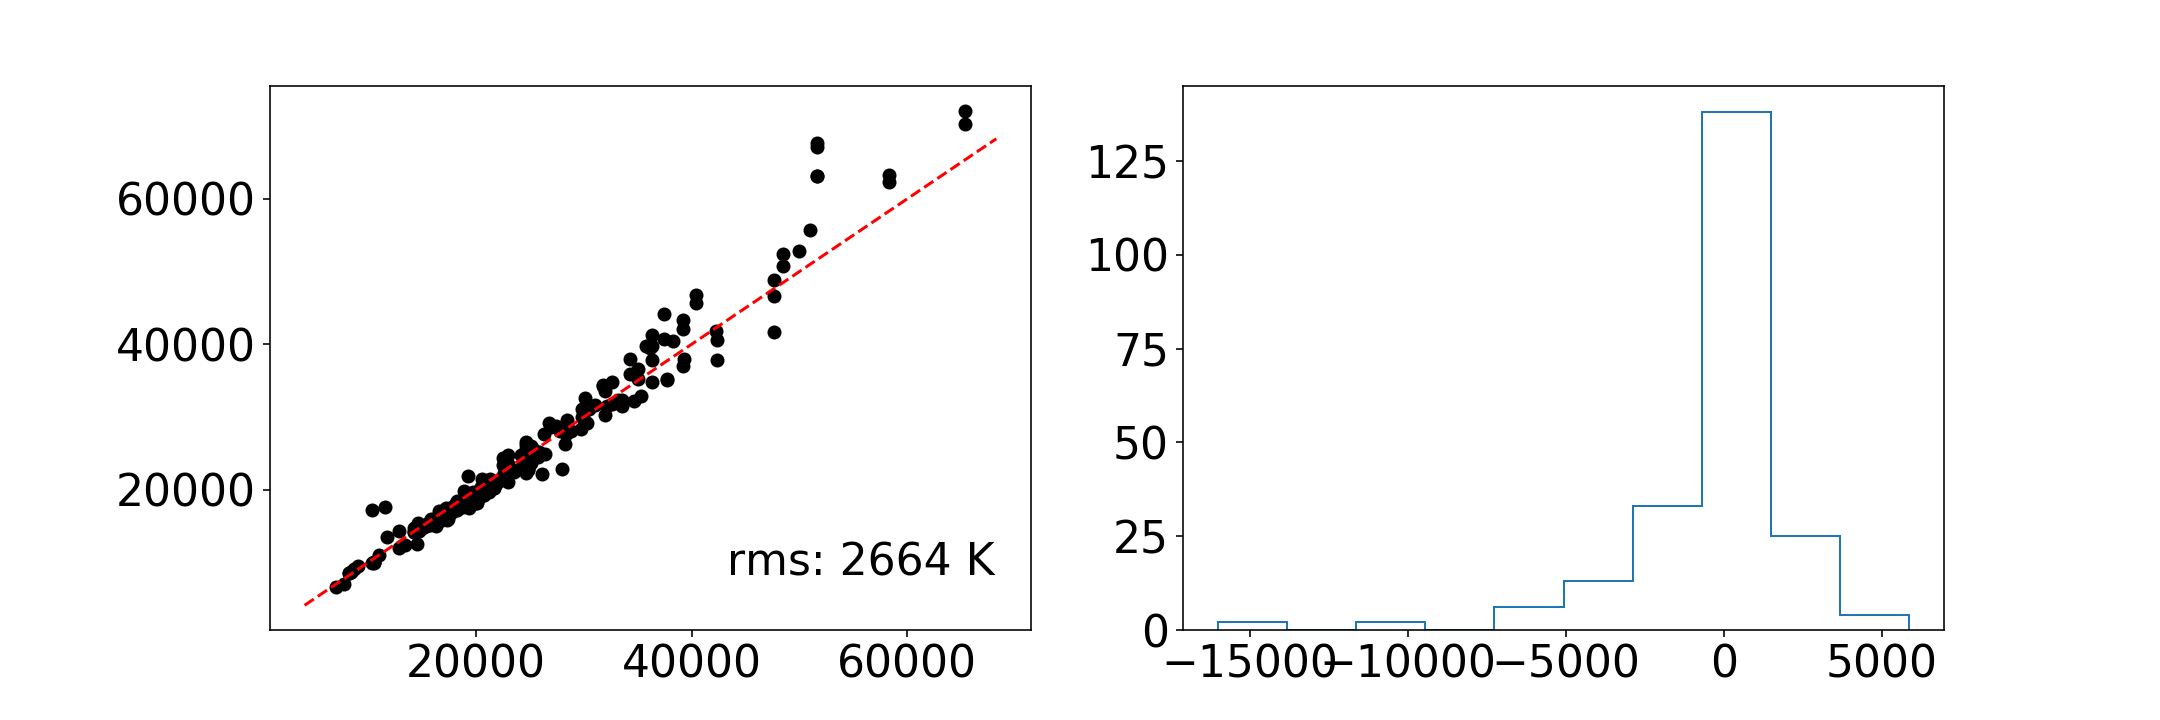

In [212]:
mlespec_Teff = [i[0] for i in mles]
lowspec_Teff = [i[0] for i in stds]
highspec_Teff = [i[0] for i in stds]
plt.figure(figsize=(15,5))
plt.subplot(121)
resid = wdtable['spec_Teff'][0:len(mles)]-mlespec_Teff
rms = np.sqrt(np.mean(resid**2))
f = plt.scatter(wdtable['spec_Teff'][0:len(mles)],mlespec_Teff, color = 'k')
plt.text(0.6,0.1,'rms: %i K'%rms,transform = f.axes.transAxes)
x = np.linspace(f.axes.get_xlim()[0],f.axes.get_xlim()[1],1000)
y = x
plt.plot(x,y,'r--')
plt.subplot(122)
plt.hist(resid, histtype = 'step');

In [1]:
%matplotlib notebook
mlespec_Teff = [i[0] for i in mles]
mask = np.asarray(mlespec_Teff) < 25000
resid = wdtable['spec_Teff'][0:len(mles)]-mlespec_Teff
rms = np.sqrt(np.mean(resid**2))
plt.figure(figsize = (15,10))
f = plt.subplot(111)
plt.errorbar(wdtable['spec_Teff'][0:len(mles)],mlespec_Teff, yerr = (lowspec_Teff,highspec_Teff), linestyle = 'None', marker = '+',\
            color = 'k', ecolor = 'c', capsize = 3)
#plt.text(0.6,0.1,'rms: %i K'%rms,transform = f.axes.transAxes)
x = np.linspace(f.axes.get_xlim()[0],f.axes.get_xlim()[1],1000)
y = x
plt.plot(x,y,'k--')
plt.xlabel('Tremblay $T_{eff}$ (K)')
plt.ylabel('Fitted $T_{eff}$ (K)')

NameError: name 'mles' is not defined

<IPython.core.display.Javascript object>


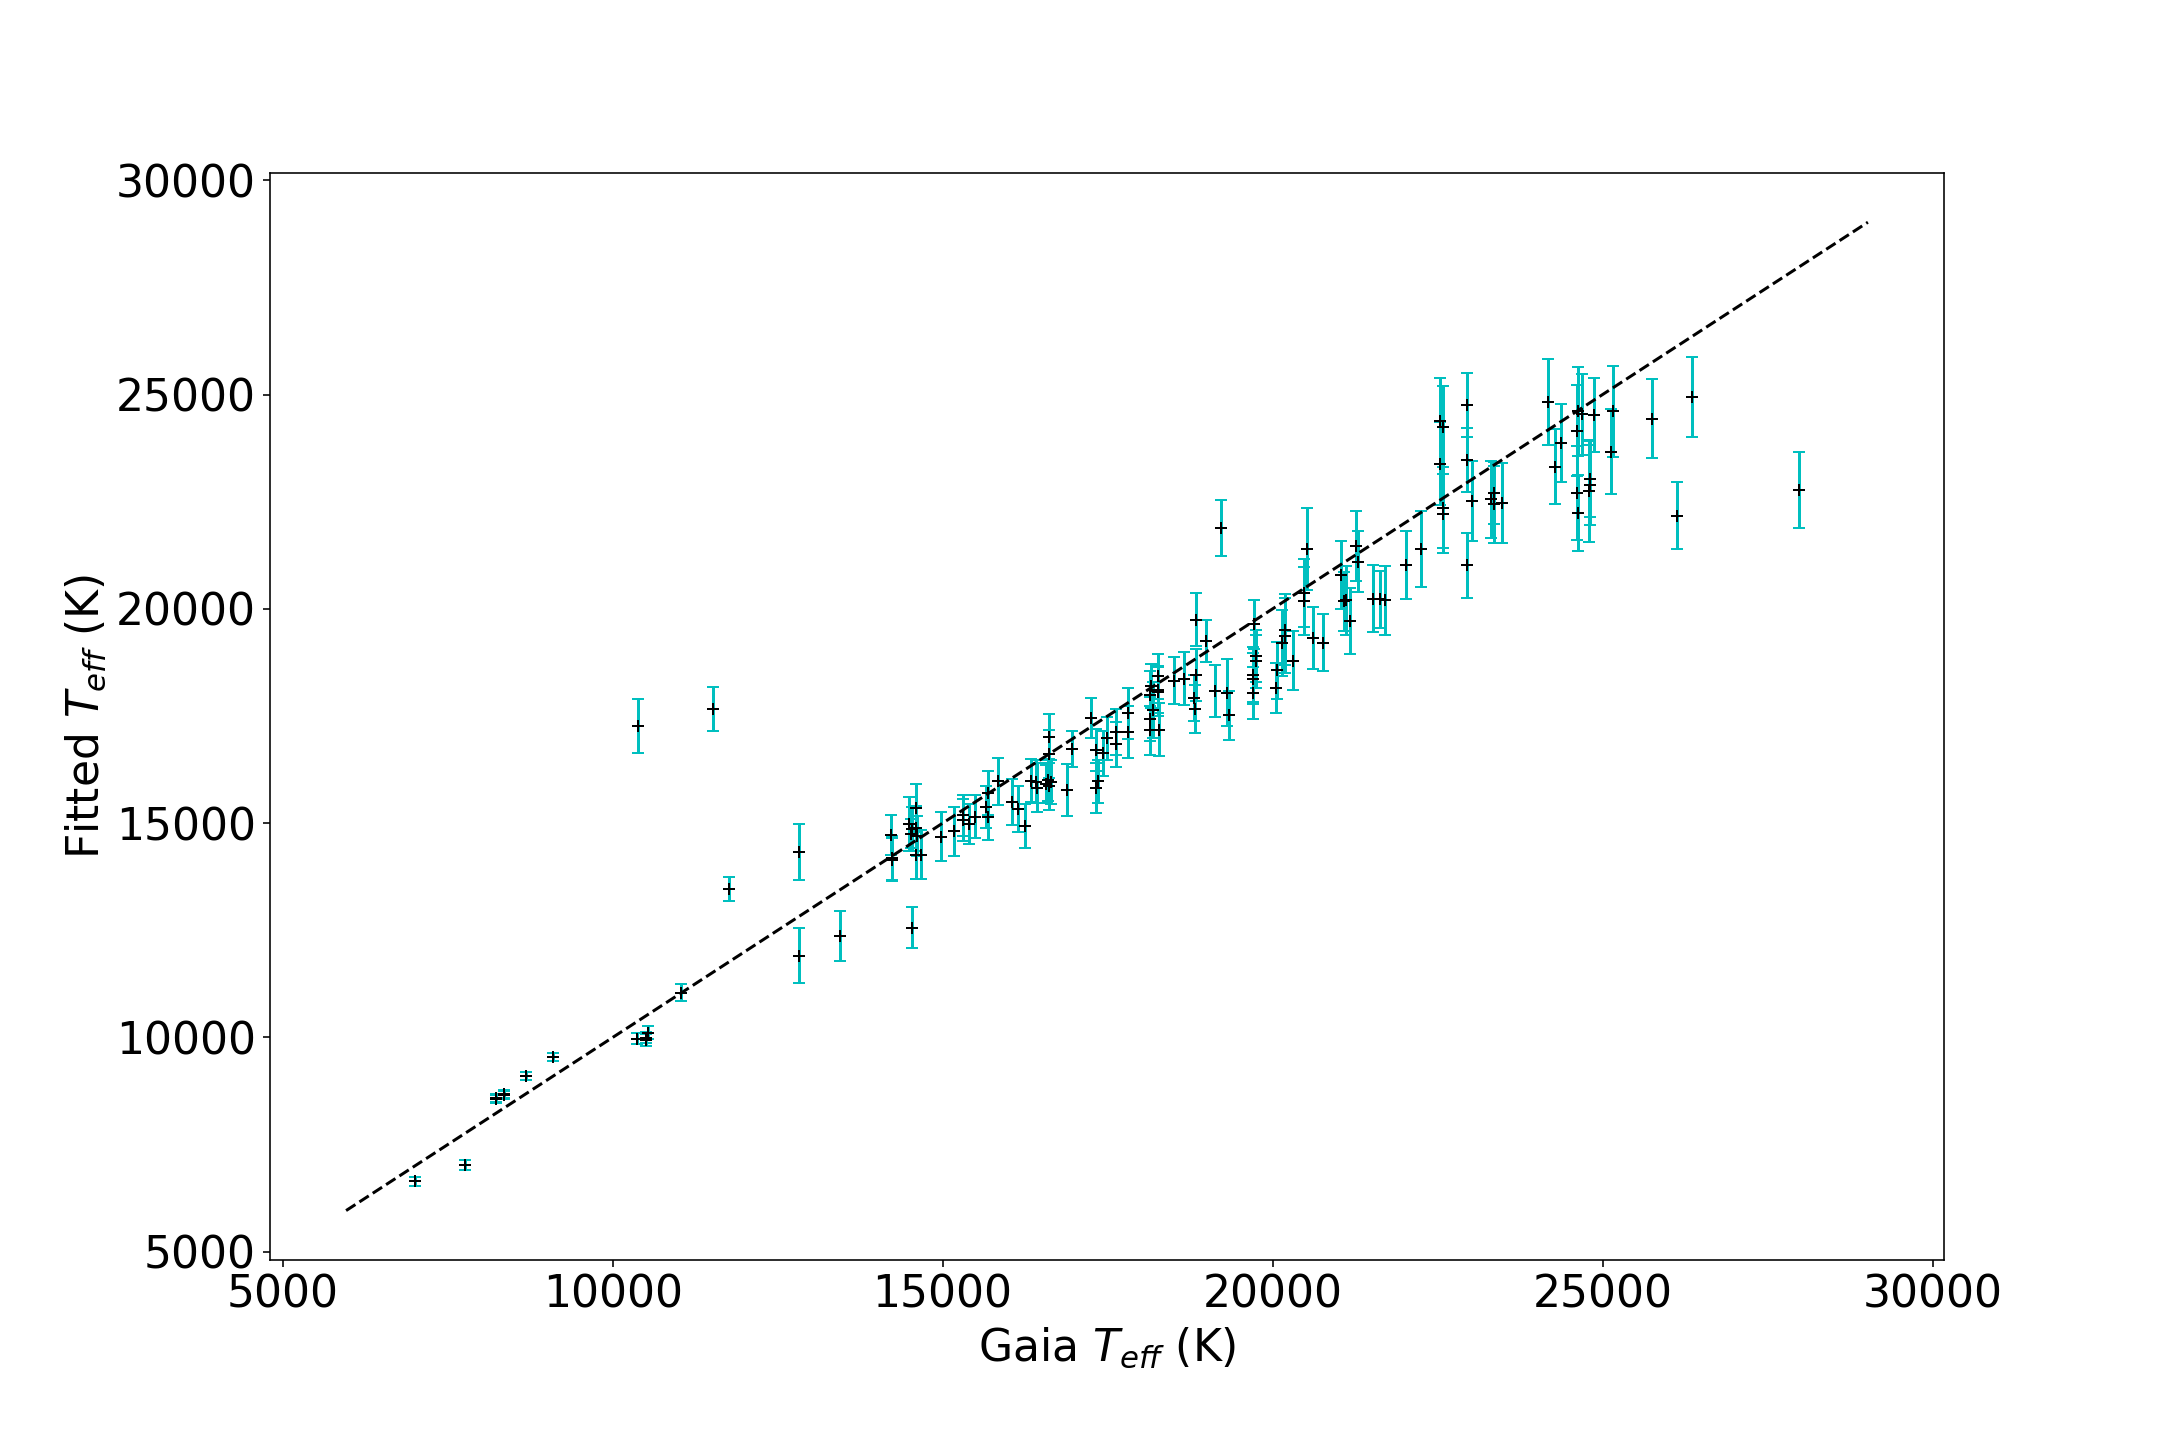

1335.8513579709293

In [218]:
%matplotlib notebook
mlespec_Teff = [i[0] for i in mles]
mask = np.asarray(mlespec_Teff) < 25000
resid = wdtable['spec_Teff'][0:len(mles)][mask]-np.asarray(mlespec_Teff)[mask]
rms = np.sqrt(np.mean(resid**2))
plt.figure(figsize = (15,10))
f = plt.subplot(111)
plt.errorbar(wdtable['spec_Teff'][0:len(mles)][mask],np.asarray(mlespec_Teff)[mask], yerr = (np.asarray(lowspec_Teff)[mask],np.asarray(highspec_Teff)[mask]), linestyle = 'None', marker = '+',\
            color = 'k', ecolor = 'c', capsize = 3)
#plt.text(0.6,0.1,'rms: %i K'%rms,transform = f.axes.transAxes)
x = np.linspace(f.axes.get_xlim()[0],f.axes.get_xlim()[1],1000)
y = x
plt.plot(x,y,'k--')
plt.xlabel('Gaia $T_{eff}$ (K)')
plt.ylabel('Fitted $T_{eff}$ (K)')
rms

<IPython.core.display.Javascript object>


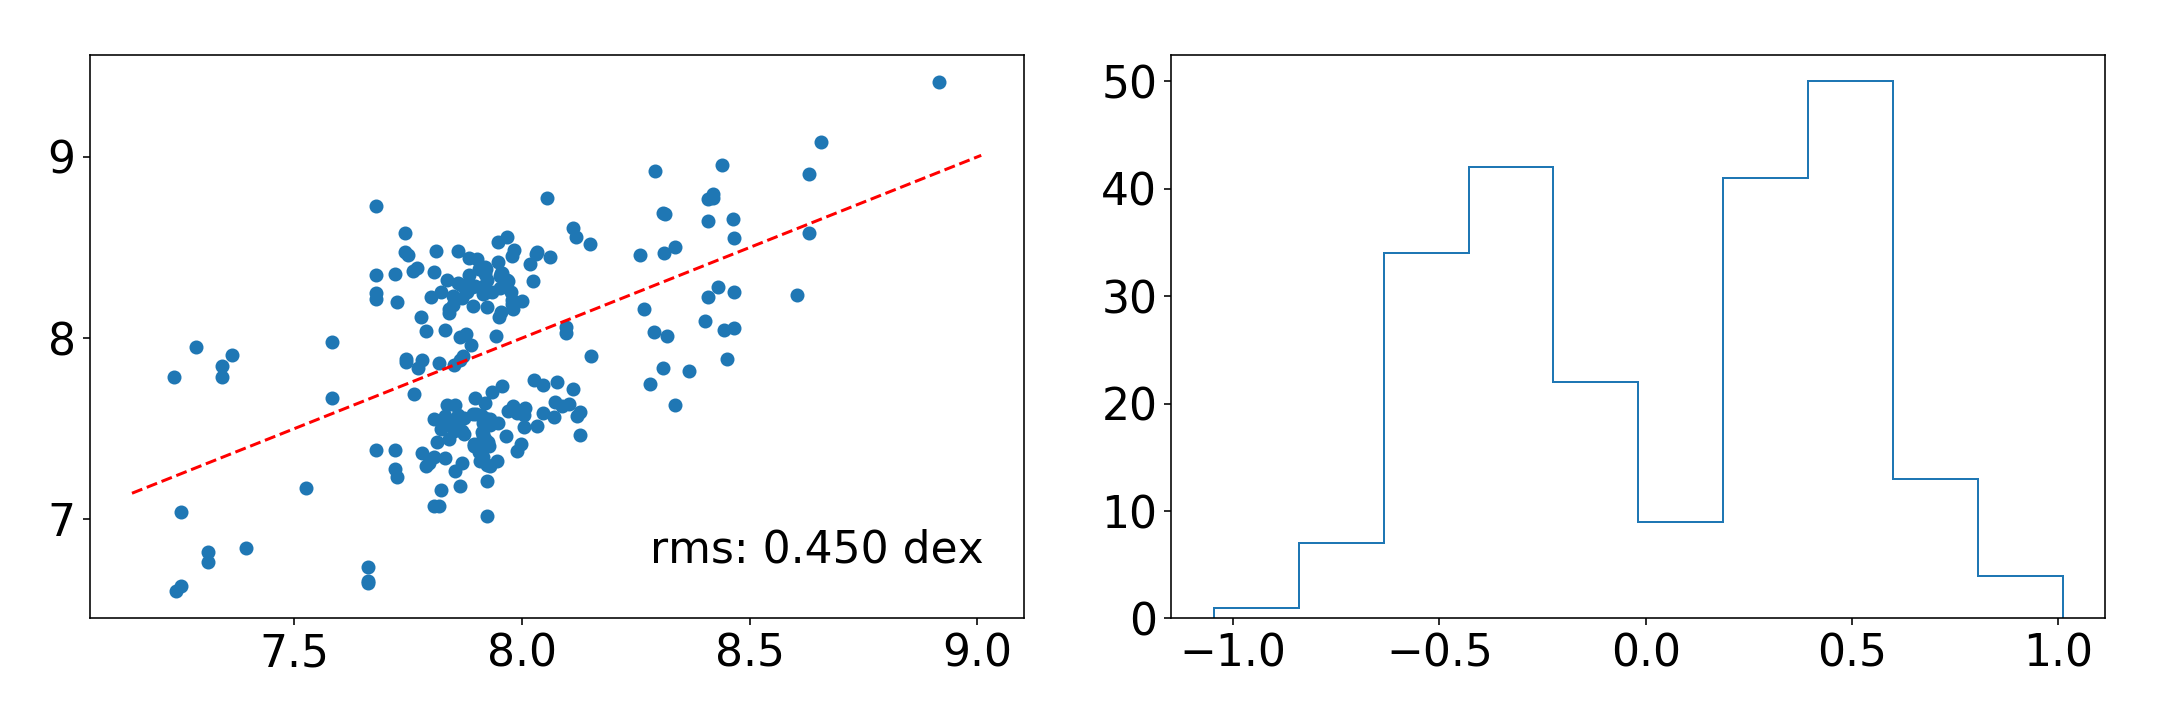

In [219]:
mlespec_logg = [i[1] for i in mles]
lowspec_logg = [i[1] for i in stds]
highspec_logg = [i[1] for i in stds]
plt.figure(figsize=(15,5))
resid = wdtable['spec_logg'][0:len(mles)]-mlespec_logg
rms = np.sqrt(np.mean(resid**2))
plt.subplot(121)
f = plt.scatter(wdtable['spec_logg'][0:len(mles)],mlespec_logg)
plt.text(0.6,0.1,'rms: %.3f dex'%rms,transform = f.axes.transAxes)
x = np.linspace(f.axes.get_xlim()[0],f.axes.get_xlim()[1],1000)
y = x
plt.plot(x,y,'r--')
plt.subplot(122)
plt.hist(resid, histtype = 'step');
plt.tight_layout()

<IPython.core.display.Javascript object>


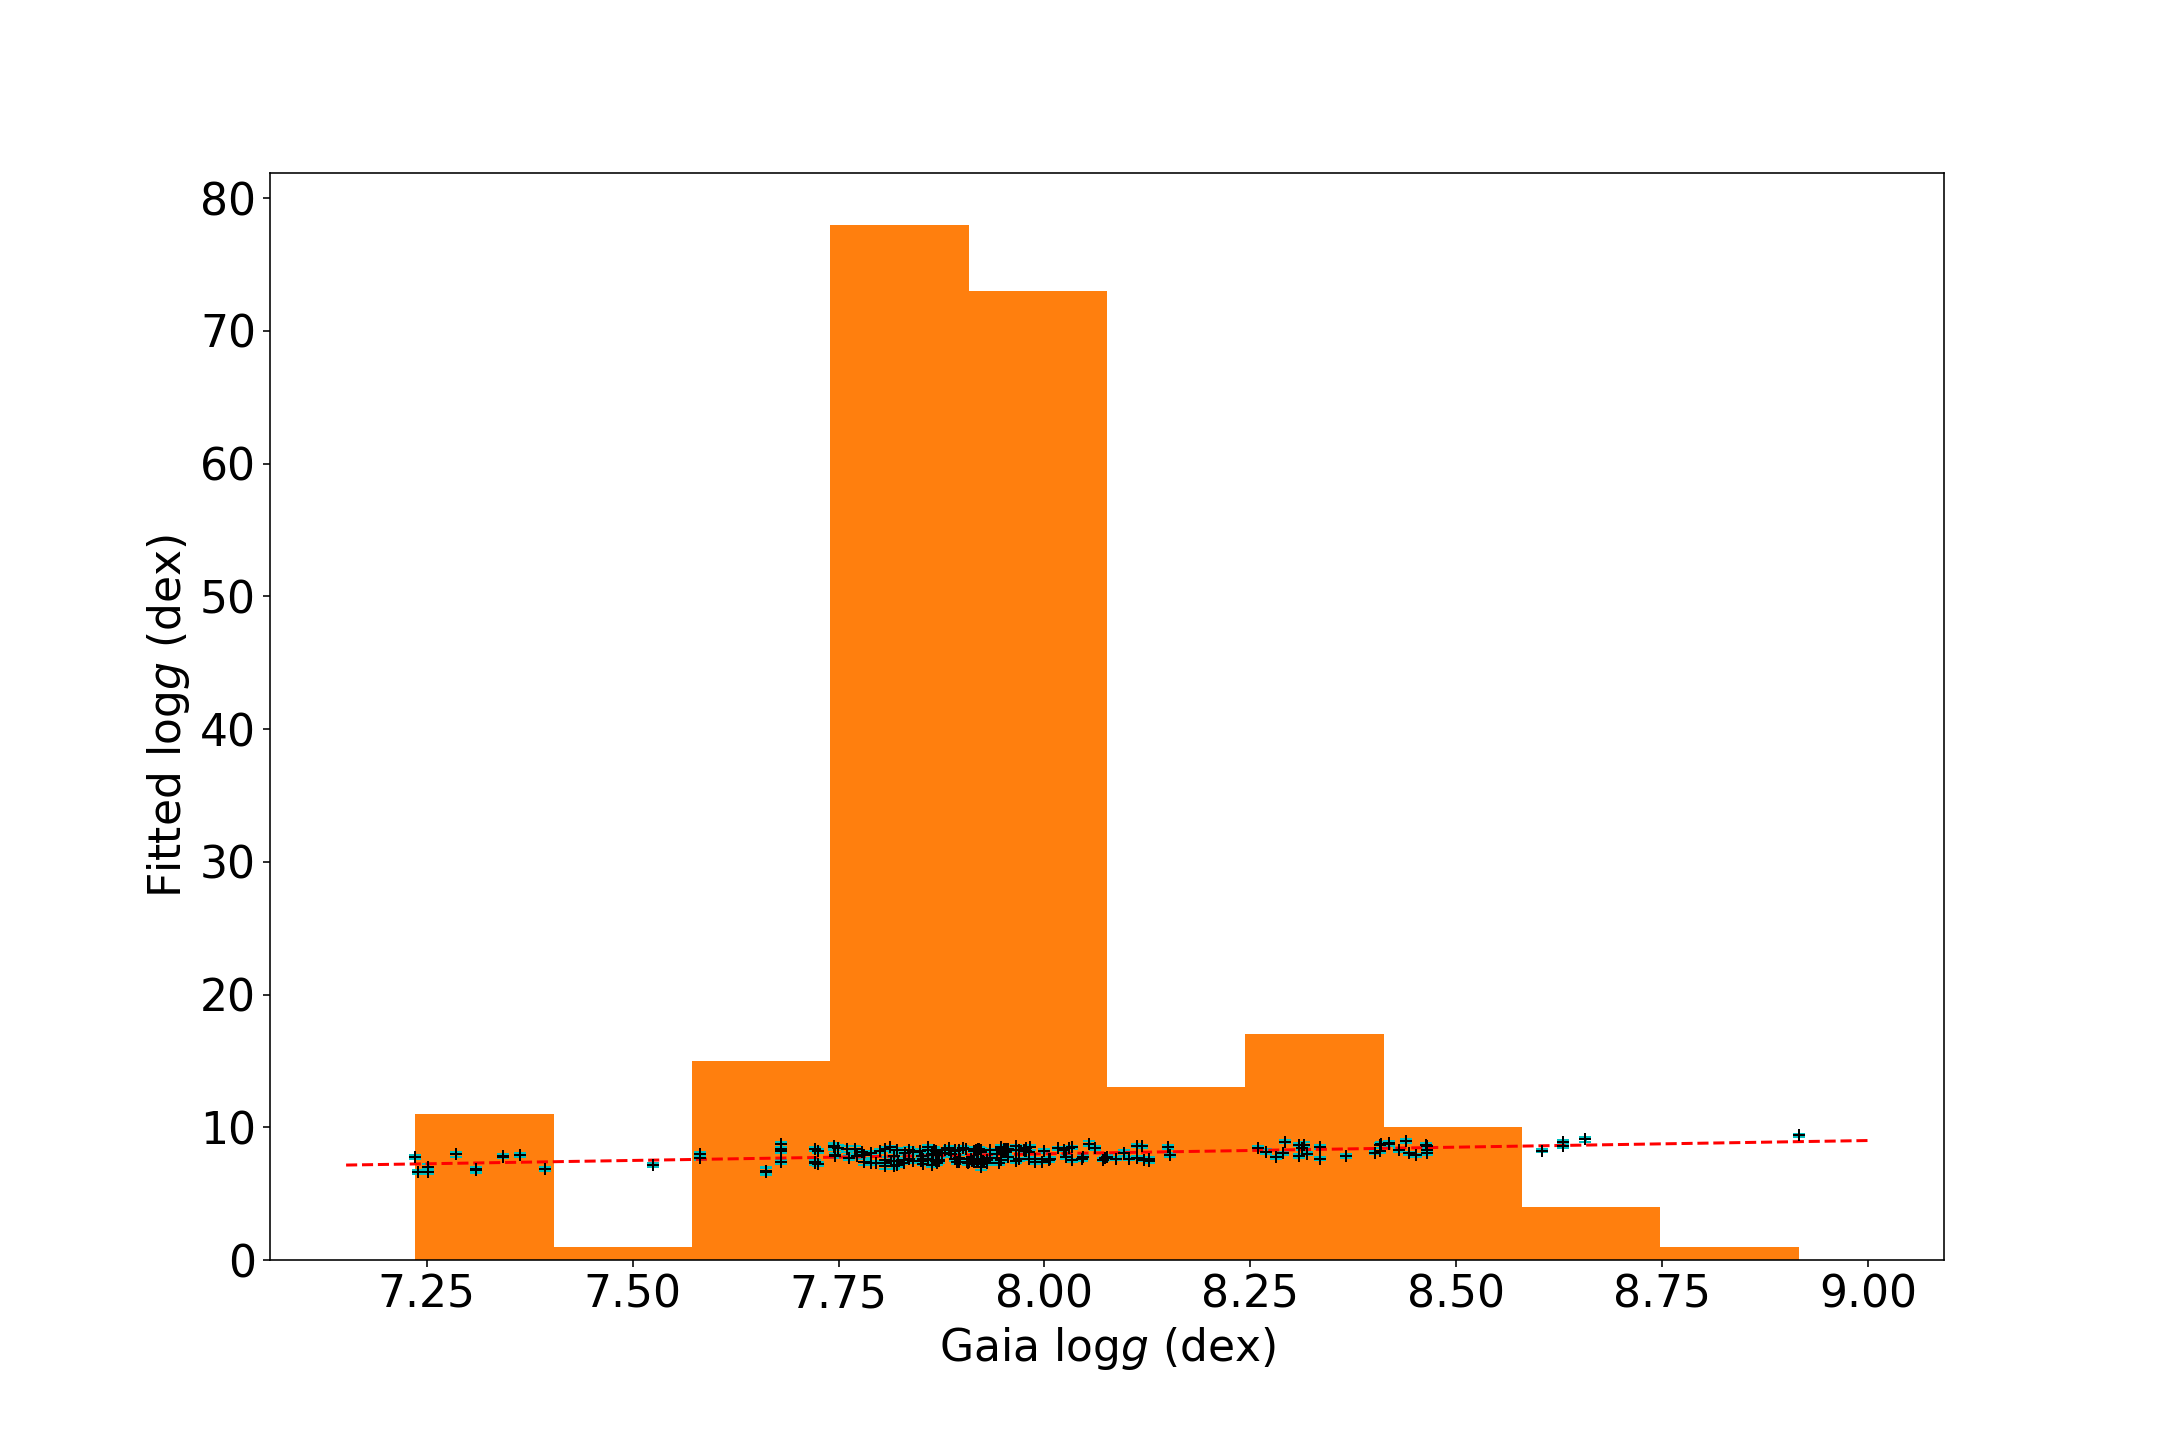

Text(0, 0.5, 'Fitted $\\log{g}$ (dex)')

In [220]:
mlespec_logg = [i[1] for i in mles]
resid = wdtable['spec_logg'][0:len(mles)]-mlespec_logg
rms = np.sqrt(np.mean(resid**2))
plt.figure(figsize = (15,10))
f = plt.subplot(111)
plt.errorbar(wdtable['spec_logg'][0:len(mles)],mlespec_logg, yerr = (lowspec_logg,highspec_logg), linestyle = 'None', marker = '+',\
            color = 'k', ecolor = 'c', capsize = 3)
#plt.text(0.6,0.1,'rms: %.2f dex'%rms,transform = f.axes.transAxes)
x = np.linspace(f.axes.get_xlim()[0],f.axes.get_xlim()[1],1000)
y = x
plt.plot(x,y,'r--')
plt.xlabel('Gaia $\log{g}$ (dex)')
plt.ylabel('Fitted $\log{g}$ (dex)')

<IPython.core.display.Javascript object>


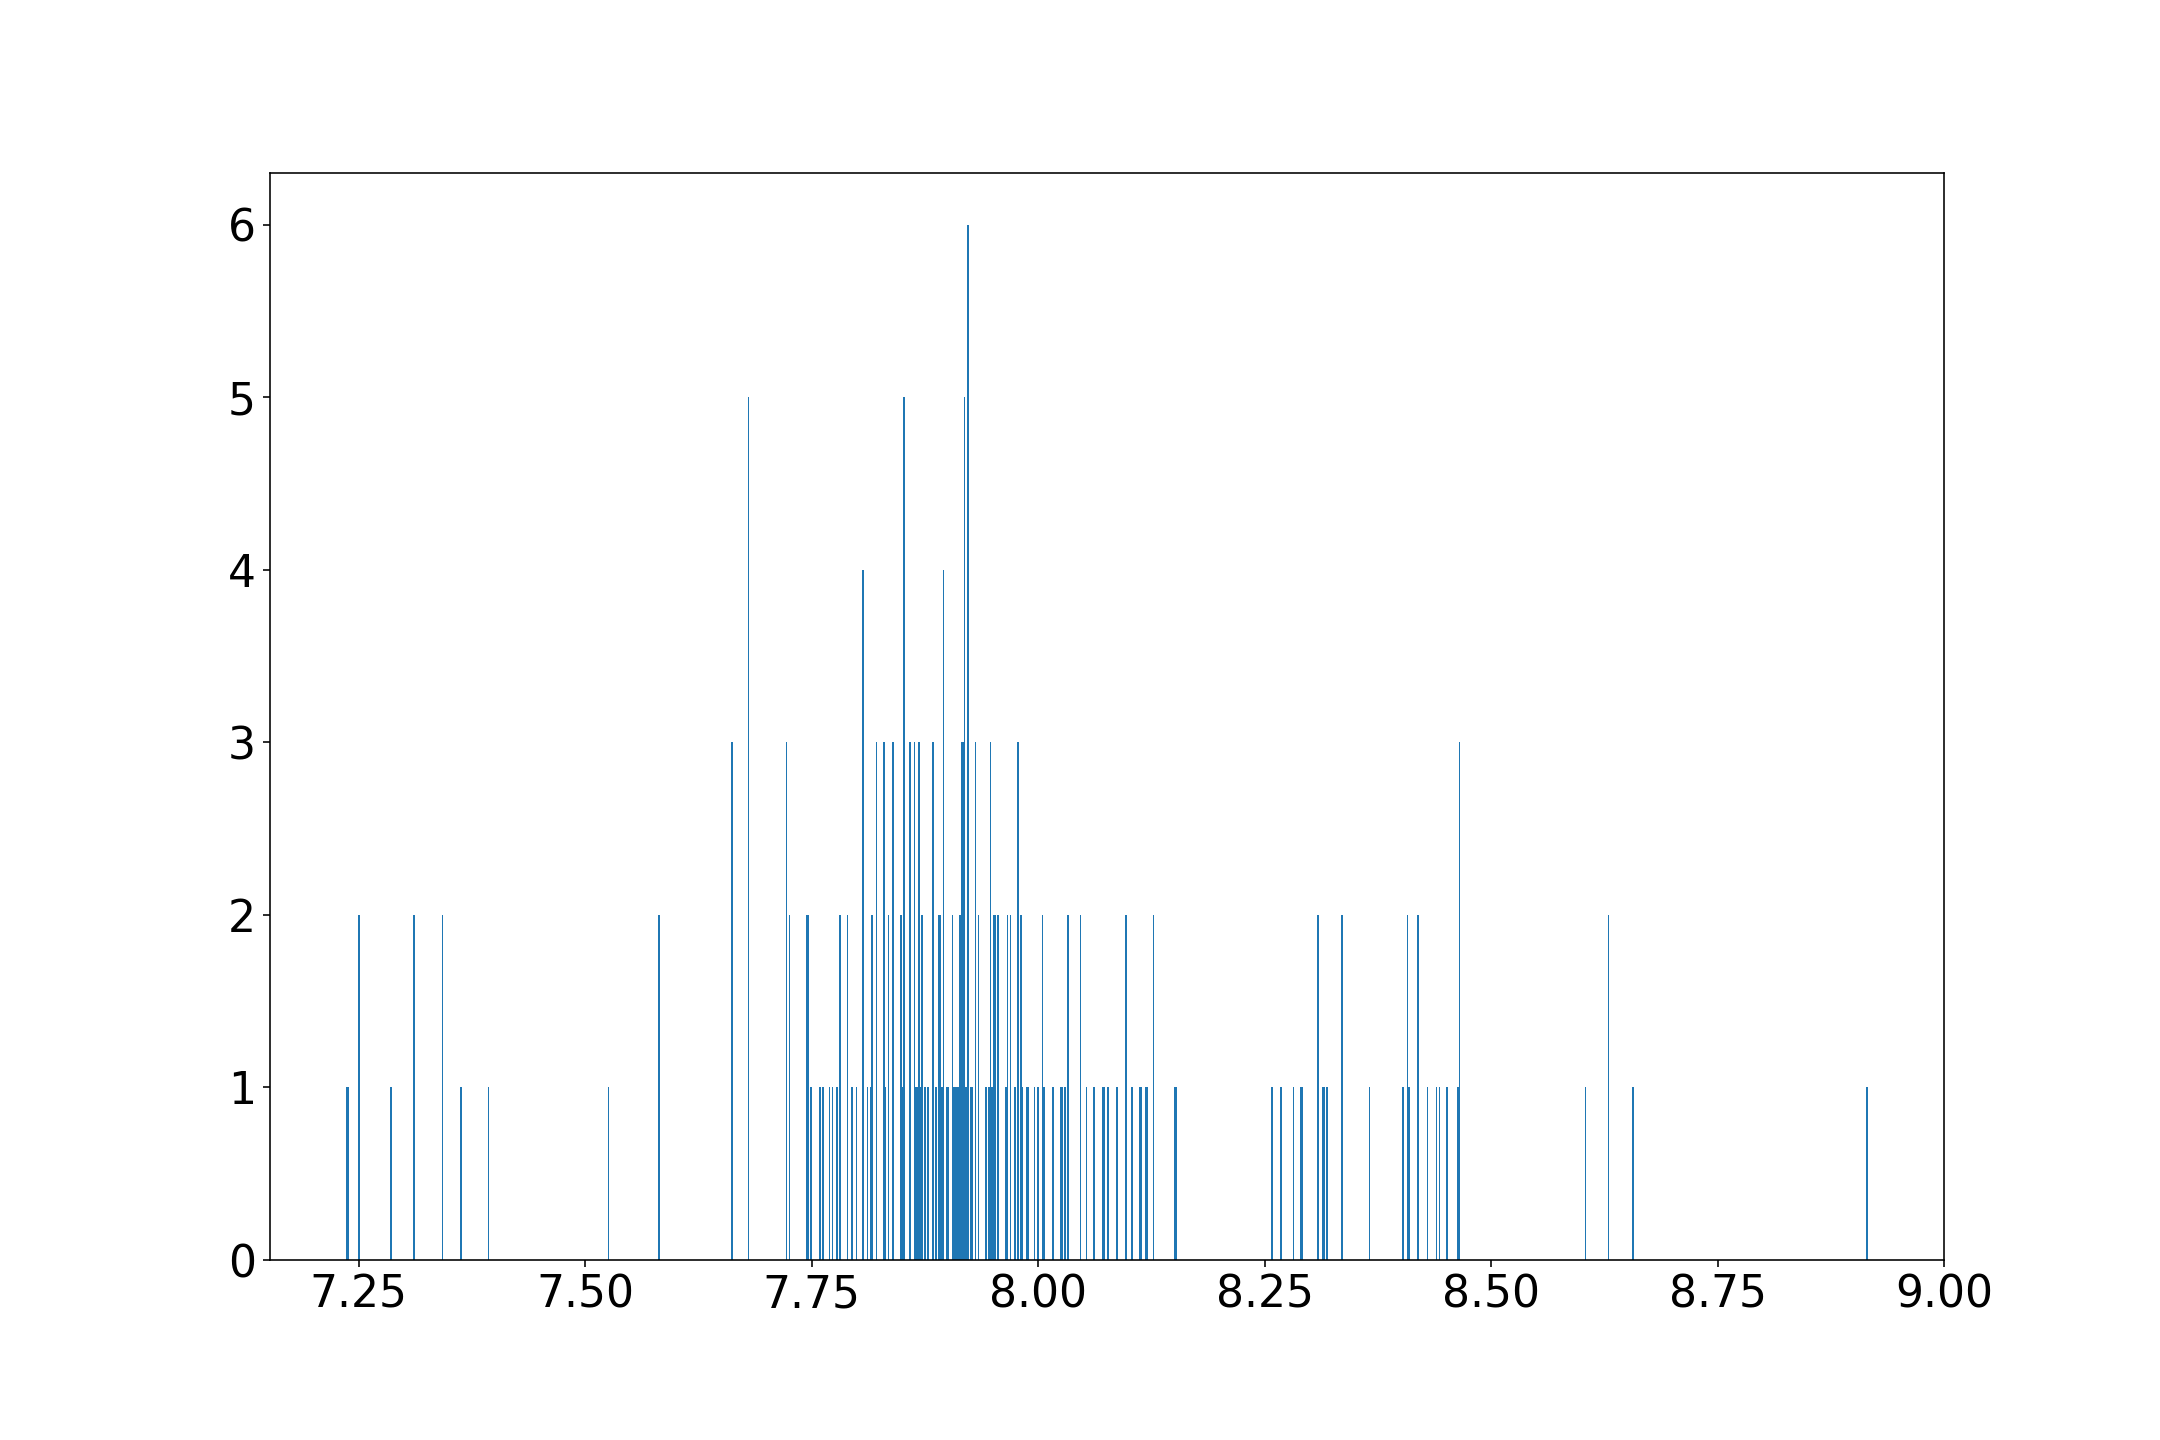

In [226]:
plt.figure()
plt.hist(wdtable['spec_logg'],bins=1000);

In [2]:
pickle.dump(results,open('223wdfits.p','wb'))

NameError: name 'pickle' is not defined

In [11]:
results = pickle.load(open('223wdfits.p','rb'))

EOFError: Ran out of input